# Semi-Supervised Architope (Financial Data)
---
- This code Implements Algorithm 3.2 of the "Architopes" paper.

#### Mode: Code-Testin Parameter(s)

In [1]:
trial_run = True

### Meta-parameters

In [2]:
# Test-size Ratio
test_size_ratio = 1
min_height = 50

In [3]:
#------------------------------------#
# Only For Motivational Example Only #
#------------------------------------#
## Hyperparameters
percentage_in_row = .25
N = 5000

def f_1(x):
    return x
def f_2(x):
    return x**2
x_0 = 0
x_end = 1

### Hyperparameters

Only turn of if running code directly here, typically this script should be run be called by other notebooks.  

In [4]:
# load dataset
results_path = "./outputs/models/"
results_tables_path = "./outputs/results/"
raw_data_path_folder = "./inputs/raw/"
data_path_folder = "./inputs/data/"

### Import

In [5]:
# Load Packages/Modules
exec(open('Init_Dump.py').read())
# Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Load Helper Function(s)
exec(open('Helper_Functions.py').read())
# Pre-process Data
if Option_Function != "Motivational_Example": 
    exec(open('Financial_Data_Preprocessor.py').read())
else:
    print(1)
    exec(open('Motivational_Example.py').read())
    print("Training Data size: ",X_train.shape[0])
# Import time separately
import time

Using TensorFlow backend.


Deep Feature Builder - Ready
Deep Classifier - Ready
1
Training Data size:  5001


### Set Seed

In [6]:
random.seed(2021)
tf.random.set_seed(2021)

#### Pre-Process:
- Convert Categorical Variables to Dummies
- Remove Bad Column
- Perform Training/Test Split

# Random Lipschitz Partition Builder

We implement the random paritioning method of [Yair Bartal](https://scholar.google.com/citations?user=eCXP24kAAAAJ&hl=en):
- [On approximating arbitrary metrices by tree metrics](https://dl.acm.org/doi/10.1145/276698.276725)

The algorithm is summarized as follow:

---

## Algorithm:
 1. Sample $\alpha \in [4^{-1},2^{-1}]$ randomly and uniformly,
 2. Apply a random suffle of the data, (a random bijection $\pi:\{i\}_{i=1}^X \rightarrow \mathbb{X}$),
 3. For $i = 1,\dots,I$:
   - Set $K_i\triangleq B\left(\pi(i),\alpha \Delta \right) - \bigcup_{j=1}^{i-1} P_j$
 
 4. Remove empty members of $\left\{K_i\right\}_{i=1}^X$.  
 
 **Return**: $\left\{K_i\right\}_{i=1}^{\tilde{X}}$.  
 
 For more details on the random-Lipschitz partition of Yair Bartal, see this [well-written blog post](https://nickhar.wordpress.com/2012/03/26/lecture-22-random-partitions-of-metric-spaces/).

## Define Random Partition Builder

In [7]:
from scipy.spatial import distance_matrix

Here we use $\Delta_{in} = Q_{q}\left(\Delta(\mathbb{X})\right)$ where $\Delta(\mathbb{X})$ is the vector of (Euclidean) distances between the given data-points, $q \in (0,1)$ is a hyper-parameter, and $Q$ is the empirical quantile function.

In [8]:
def Random_Lipschitz_Partioner(Min_data_size_percentage,q_in, X_train_in,y_train_in, CV_folds_failsafe, min_size):
       
    #-----------------------#
    # Reset Seed Internally #
    #-----------------------#
    random.seed(2020)
    np.random.seed(2020)

    #-------------------------------------------#
    #-------------------------------------------#
    # 1) Sample radius from unifom distribution #
    #-------------------------------------------#
    #-------------------------------------------#
    alpha = np.random.uniform(low=.25,high=.5,size=1)[0]

    #-------------------------------------#
    #-------------------------------------#
    # 2) Apply Random Bijection (Shuffle) #
    #-------------------------------------#
    #-------------------------------------#
    X_train_in_shuffled = X_train_in#.sample(frac=1)
    y_train_in_shuffled = y_train_in#.sample(frac=1)

    #--------------------#
    #--------------------#
    # X) Initializations #
    #--------------------#
    #--------------------#
    # Compute-data-driven radius
    Delta_X = distance_matrix(X_train_in_shuffled,X_train_in_shuffled)[::,0]
    Delta_in = np.quantile(Delta_X,q_in)

    # Initialize Random Radius
    rand_radius = Delta_in*alpha

    # Initialize Data_sizes & ratios
    N_tot = X_train_in.shape[0] #<- Total number of data-points in input data-set!
    N_radios = np.array([])
    N_pool_train_loop = N_tot
    # Initialize List of Dataframes
    X_internal_train_list = list()
    y_internal_train_list = list()

    # Initialize Partioned Data-pool
    X_internal_train_pool = X_train_in_shuffled
    y_internal_train_pool = y_train_in_shuffled

    # Initialize counter 
    part_current_loop = 0

    #----------------------------#
    #----------------------------#
    # 3) Iteratively Build Parts #
    #----------------------------#
    #----------------------------#

    while ((N_pool_train_loop/N_tot > Min_data_size_percentage) or (X_internal_train_pool.empty == False)):
        # Extract Current Center
        center_loop = X_internal_train_pool.iloc[0]
        # Compute Distances
        ## Training
        distances_pool_loop_train = X_internal_train_pool.sub(center_loop)
        distances_pool_loop_train = np.array(np.sqrt(np.square(distances_pool_loop_train).sum(axis=1)))
        # Evaluate which Distances are less than the given random radius
        Part_train_loop = X_internal_train_pool[distances_pool_loop_train<rand_radius]
        Part_train_loop_y = y_internal_train_pool[distances_pool_loop_train<rand_radius]

        # Remove all data-points which are "too small"
        if X_internal_train_pool.shape[0] > max(CV_folds,4):
            # Append Current part to list
            X_internal_train_list.append(Part_train_loop)
            y_internal_train_list.append(Part_train_loop_y)

        # Remove current part from pool 
        X_internal_train_pool = X_internal_train_pool[(np.logical_not(distances_pool_loop_train<rand_radius))]
        y_internal_train_pool = y_internal_train_pool[(np.logical_not(distances_pool_loop_train<rand_radius))]

        # Update Current size of pool of training data
        N_pool_train_loop = X_internal_train_pool.shape[0]
        N_radios = np.append(N_radios,(N_pool_train_loop/N_tot))

        # Update Counter
        part_current_loop = part_current_loop +1
        
        # Update User
        print((N_pool_train_loop/N_tot))


    # Post processing #
    #-----------------#
    # Remove Empty Partitions
    N_radios = N_radios[N_radios>0]
    
    
    #-----------------------------------------------------------------#
    # Combine parts which are too small to perform CV without an error
    #-----------------------------------------------------------------#
    # Initialize lists (partitions) with "enough" datums per part
    X_internal_train_list_good = list()
    y_internal_train_list_good = list()
    X_small_parts = list()
    y_small_parts = list()
    # Initialize first list item test
    is_first = True
    # Initialize counter
    goods_counter = 0
    for search_i in range(len(X_internal_train_list)):
        number_of_instances_in_part = len(X_internal_train_list[search_i]) 
        if number_of_instances_in_part < max(CV_folds_failsafe,min_size):
            # Check if first 
            if is_first:
                # Initialize set of small X_parts
                X_small_parts = X_internal_train_list[search_i]
                # Initialize set of small y_parts
                y_small_parts = y_internal_train_list[search_i]

                # Set is_first to false
                is_first = False
            else:
                X_small_parts = X_small_parts.append(X_internal_train_list[search_i])
                y_small_parts = np.append(y_small_parts,y_internal_train_list[search_i])
#                 y_small_parts = y_small_parts.append(y_internal_train_list[search_i])
        else:
            # Append to current list
            X_internal_train_list_good.append(X_internal_train_list[search_i])
            y_internal_train_list_good.append(y_internal_train_list[search_i])
            # Update goods counter 
            goods_counter = goods_counter +1

    # Append final one to good list
    X_internal_train_list_good.append(X_small_parts)
    y_internal_train_list_good.append(y_small_parts)

    # reset is_first to false (inscase we want to re-run this particular block)
    is_first = True

    # Set good lists to regular lists
    X_internal_train_list = X_internal_train_list_good
    y_internal_train_list = y_internal_train_list_good
    
    
    
    # Return Value #
    #--------------#
    return [X_internal_train_list, y_internal_train_list, N_radios]

# Apply Random Partitioner to the given Dataset

In [9]:
import time
partitioning_time_begin = time.time()

In [10]:
if Option_Function == 'SnP':
    q_in_auto = .8
    Min_data_size_percentage_auto = .1
    min_size_part = 100
else:
    if Option_Function == 'crypto':
        q_in_auto = .99
        Min_data_size_percentage_auto = .3
        min_size_part = 100
    if Option_Function == 'Motivational_Example':
        q_in_auto = .5
        Min_data_size_percentage_auto = .5
        min_size_part = 10
        # Partition Based on Y
        holder_temp = data_y
        data_y = X_train
        X_train = holder_temp
    else:
        q_in_auto = .5
        Min_data_size_percentage_auto = .3
        min_size_part = 100

In [11]:
# Initialize Number of Parts currently generated
N_parts_generated = 0

# Generate Partition (with option to regernerate if only 1 part is randomly produced)
while N_parts_generated < 2:
    # Generate Parts
    X_parts_list, y_parts_list, N_ratios = Random_Lipschitz_Partioner(Min_data_size_percentage=Min_data_size_percentage_auto, 
                                                                      q_in=q_in_auto, 
                                                                      X_train_in=X_train, 
                                                                      y_train_in=data_y, 
                                                                      CV_folds_failsafe=CV_folds,
                                                                      min_size = min_size_part)
    
    # Update Number of Parts
    N_parts_generated = len(X_parts_list)
    # Shuffle hyperparameters
    Min_data_size_percentage_auto = (Min_data_size_percentage_auto + random.uniform(0,.3)) % 1
    q_in_auto = (q_in_auto + random.uniform(0,.3)) % 1
    
    # Update User
    print('The_parts_listhe number of parts are: ' + str(len(X_parts_list))+'.')
    
# Trash removal (removes empty parts)
X_parts_list = list(filter(([]).__ne__, X_parts_list))
y_parts_list = list(filter(([]).__ne__, y_parts_list))
    
    
# ICML Rebuttle Deadline = Coersion!
if Option_Function == 'Motivational_Example':
    # Flipback After Partitioning Based on Y (since code was made for partitioning in X!)
    holder_temp = data_y
    data_y = X_train
    X_train = holder_temp
    holder_temp = y_parts_list
    y_parts_list = X_parts_list
    X_parts_list = holder_temp

0.6660667866426715
0.42451509698060386
0.2501499700059988
0.047590481903619274
0.0
The_parts_listhe number of parts are: 6.


In [12]:
partitioning_time = time.time() - partitioning_time_begin

In [13]:
print('The_parts_listhe number of parts are: ' + str(len(X_parts_list))+'.')

The_parts_listhe number of parts are: 5.


#### Building Training Predictions on each part
- Train locally (on each "naive part")
- Generate predictions for (full) training and testings sets respectively, to be used in training the classifer and for prediction, respectively.  
- Generate predictions on all of testing-set (will be selected between later using classifier)

In [14]:
# Time-Elapse (Start) for Training on Each Part
Architope_partition_training_begin = time.time()
# Initialize running max for Parallel time
Architope_partitioning_max_time_running = -math.inf # Initialize slowest-time at - infinity to force updating!
# Initialize N_parameter counter for Architope
N_params_Architope = 0

In [15]:
# Silly Coercsion for ICML rebuttle deadline timeline
if Option_Function == 'Motivational_Example':
    Iteration_Length = len(X_parts_list) -1
else:
    Iteration_Length = len(X_parts_list)

    
# Train each part!
for current_part in range(Iteration_Length):
    #==============#
    # Timer(begin) #
    #==============#
    current_part_training_time_for_parallel_begin = time.time()
    
    
    # Initializations #
    #-----------------#
    # Reload Grid
    exec(open('Grid_Enhanced_Network.py').read())
    # Modify heights according to optimal (data-driven) rule (with threshold)
    current_height = np.ceil(np.array(param_grid_Vanilla_Nets['height'])*N_ratios[current_part])
    current_height_threshold = np.repeat(min_height,(current_height.shape[0]))
    current_height = np.maximum(current_height,current_height_threshold)
    current_height = current_height.astype(int).tolist()
    param_grid_Vanilla_Nets['height'] = current_height
    # Automatically Fix Input Dimension
    param_grid_Vanilla_Nets['input_dim'] = [X_train.shape[1]]
    param_grid_Vanilla_Nets['output_dim'] = [1]
    
    # Update User #
    #-------------#
    print('Status: Current part: ' + str(current_part) + ' out of : '+str(len(X_parts_list)) +' parts.')
    print('Heights to iterate over: '+str(current_height))
    
    # Generate Prediction(s) on current Part #
    #----------------------------------------#
    # Failsafe (number of data-points)
    CV_folds_failsafe = min(CV_folds,max(1,(X_train.shape[0]-1)))
    # Train Network
    y_hat_train_full_loop, y_hat_test_full_loop, N_params_Architope_loop = build_ffNN(n_folds = CV_folds_failsafe, 
                                                                                     n_jobs = n_jobs,
                                                                                     n_iter = n_iter, 
                                                                                     param_grid_in = param_grid_Vanilla_Nets, 
                                                                                     X_train= X_parts_list[current_part], 
                                                                                     y_train=y_parts_list[current_part],
                                                                                     X_test_partial=X_train,
                                                                                     X_test=X_test)
    
    # Append predictions to data-frames
    ## If first prediction we initialize data-frames
    if current_part==0:
        # Register quality
        training_quality = np.array(np.abs(y_hat_train_full_loop-y_train))
        training_quality = training_quality.reshape(training_quality.shape[0],1)

        # Save Predictions
        predictions_train = y_hat_train_full_loop
        predictions_train = predictions_train.reshape(predictions_train.shape[0],1)
        predictions_test = y_hat_test_full_loop
        predictions_test = predictions_test.reshape(predictions_test.shape[0],1)
        
        
    ## If not first prediction we append to already initialized dataframes
    else:
    # Register Best Scores
        #----------------------#
        # Write Predictions 
        # Save Predictions
        y_hat_train_loop = y_hat_train_full_loop.reshape(predictions_train.shape[0],1)
        predictions_train = np.append(predictions_train,y_hat_train_loop,axis=1)
        y_hat_test_loop = y_hat_test_full_loop.reshape(predictions_test.shape[0],1)
        predictions_test = np.append(predictions_test,y_hat_test_loop,axis=1)
        
        # Evaluate Errors #
        #-----------------#
        # Training
        prediction_errors = np.abs(y_hat_train_loop.reshape(-1,)-y_train)
        training_quality = np.append(training_quality,prediction_errors.reshape(training_quality.shape[0],1),axis=1)
        
    #============#
    # Timer(end) #
    #============#
    current_part_training_time_for_parallel = time.time() - current_part_training_time_for_parallel_begin
    Architope_partitioning_max_time_running = max(Architope_partitioning_max_time_running,current_part_training_time_for_parallel)

    #============---===============#
    # N_parameter Counter (Update) #
    #------------===---------------#
    N_params_Architope = N_params_Architope + N_params_Architope_loop

# Update User
#-------------#
print(' ')
print(' ')
print(' ')
print('----------------------------------------------------')
print('Feature Generation (Learning Phase): Score Generated')
print('----------------------------------------------------')
print(' ')
print(' ')
print(' ')

Status: Current part: 0 out of : 5 parts.
Heights to iterate over: [134]
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:  2.4min finished


Epoch 1/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0366 - mse: 0.0026 - mae: 0.0366 - mape: 156.6241
Epoch 2/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0342 - mse: 0.0022 - mae: 0.0342 - mape: 166.0662
Epoch 3/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0296 - mse: 0.0017 - mae: 0.0296 - mape: 124.6493
Epoch 4/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0188 - mse: 6.5135e-04 - mae: 0.0188 - mape: 87.7521
Epoch 5/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0166 - mse: 5.6222e-04 - mae: 0.0166 - mape: 106.8333
Epoch 6/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0165 - mse: 5.5098e-04 - mae: 0.0165 - mape: 104.0442
Epoch 7/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0163 - mse: 5.5570e-04 - mae: 0.0163 - mape: 104.8026
Epoch 8/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0163 - mse:

105/105 [==============================] - 0s 2ms/step - loss: 0.0060 - mse: 1.6779e-04 - mae: 0.0060 - mape: 32.6208
Epoch 64/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0059 - mse: 1.6884e-04 - mae: 0.0059 - mape: 32.4515
Epoch 65/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0059 - mse: 1.7426e-04 - mae: 0.0059 - mape: 29.5961
Epoch 66/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0059 - mse: 1.7362e-04 - mae: 0.0059 - mape: 29.6912
Epoch 67/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0059 - mse: 1.7397e-04 - mae: 0.0059 - mape: 30.2250
Epoch 68/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0059 - mse: 1.6754e-04 - mae: 0.0059 - mape: 31.5680
Epoch 69/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0060 - mse: 1.7400e-04 - mae: 0.0060 - mape: 31.8071
Epoch 70/1000
105/105 [==============================] - 0s 3ms/step - loss: 0.0058 - mse:

Epoch 125/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0055 - mse: 1.6279e-04 - mae: 0.0055 - mape: 33.9865
Epoch 126/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0055 - mse: 1.6331e-04 - mae: 0.0055 - mape: 33.5405
Epoch 127/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0055 - mse: 1.6423e-04 - mae: 0.0055 - mape: 33.1665
Epoch 128/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0054 - mse: 1.6307e-04 - mae: 0.0054 - mape: 33.7866
Epoch 129/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0055 - mse: 1.6039e-04 - mae: 0.0055 - mape: 34.0982
Epoch 130/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0055 - mse: 1.6235e-04 - mae: 0.0055 - mape: 34.0455
Epoch 131/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0055 - mse: 1.6214e-04 - mae: 0.0055 - mape: 34.1294
Epoch 132/1000
105/105 [==============================] - 0s 2ms/step

105/105 [==============================] - 0s 2ms/step - loss: 0.0052 - mse: 1.4597e-04 - mae: 0.0052 - mape: 43.4507
Epoch 187/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0053 - mse: 1.5137e-04 - mae: 0.0053 - mape: 42.6262
Epoch 188/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0054 - mse: 1.4866e-04 - mae: 0.0054 - mape: 43.6336
Epoch 189/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0055 - mse: 1.4801e-04 - mae: 0.0055 - mape: 43.8638
Epoch 190/1000
105/105 [==============================] - 0s 3ms/step - loss: 0.0053 - mse: 1.4708e-04 - mae: 0.0053 - mape: 42.9154
Epoch 191/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0052 - mse: 1.4881e-04 - mae: 0.0052 - mape: 41.8342
Epoch 192/1000
105/105 [==============================] - 0s 3ms/step - loss: 0.0052 - mse: 1.4946e-04 - mae: 0.0052 - mape: 41.6055
Epoch 193/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0053

105/105 [==============================] - 0s 3ms/step - loss: 0.0052 - mse: 1.4612e-04 - mae: 0.0052 - mape: 44.3144
Epoch 248/1000
105/105 [==============================] - 0s 4ms/step - loss: 0.0052 - mse: 1.4343e-04 - mae: 0.0052 - mape: 46.1357
Epoch 249/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0052 - mse: 1.4594e-04 - mae: 0.0052 - mape: 45.0502
Epoch 250/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0053 - mse: 1.4604e-04 - mae: 0.0053 - mape: 45.0505
Epoch 251/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0053 - mse: 1.4989e-04 - mae: 0.0053 - mape: 42.8855
Epoch 252/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0053 - mse: 1.4686e-04 - mae: 0.0053 - mape: 45.3758
Epoch 253/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0052 - mse: 1.4674e-04 - mae: 0.0052 - mape: 44.4719
Epoch 254/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0052

105/105 [==============================] - 0s 2ms/step - loss: 0.0052 - mse: 1.4840e-04 - mae: 0.0052 - mape: 44.1006
Epoch 309/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0052 - mse: 1.4242e-04 - mae: 0.0052 - mape: 48.3467
Epoch 310/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0052 - mse: 1.4470e-04 - mae: 0.0052 - mape: 46.4374
Epoch 311/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0052 - mse: 1.4588e-04 - mae: 0.0052 - mape: 44.5269
Epoch 312/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0052 - mse: 1.4836e-04 - mae: 0.0052 - mape: 43.7957
Epoch 313/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0052 - mse: 1.4365e-04 - mae: 0.0052 - mape: 46.1698
Epoch 314/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0053 - mse: 1.4073e-04 - mae: 0.0053 - mape: 48.6628
Epoch 315/1000
105/105 [==============================] - 0s 4ms/step - loss: 0.0053

105/105 [==============================] - 0s 2ms/step - loss: 0.0052 - mse: 1.4836e-04 - mae: 0.0052 - mape: 44.2495
Epoch 370/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0052 - mse: 1.4447e-04 - mae: 0.0052 - mape: 46.8614
Epoch 371/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0053 - mse: 1.4686e-04 - mae: 0.0053 - mape: 45.4646
Epoch 372/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0052 - mse: 1.4342e-04 - mae: 0.0052 - mape: 47.0196
Epoch 373/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0051 - mse: 1.4579e-04 - mae: 0.0051 - mape: 45.0195
Epoch 374/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0052 - mse: 1.4270e-04 - mae: 0.0052 - mape: 47.9340
Epoch 375/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0052 - mse: 1.4231e-04 - mae: 0.0052 - mape: 46.7432
Epoch 376/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0052

105/105 [==============================] - 0s 2ms/step - loss: 0.0051 - mse: 1.4544e-04 - mae: 0.0051 - mape: 46.2409
Epoch 431/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0051 - mse: 1.4336e-04 - mae: 0.0051 - mape: 47.7136
Epoch 432/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0051 - mse: 1.4477e-04 - mae: 0.0051 - mape: 48.6252
Epoch 433/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0052 - mse: 1.4624e-04 - mae: 0.0052 - mape: 45.5310
Epoch 434/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0052 - mse: 1.4484e-04 - mae: 0.0052 - mape: 48.5839
Epoch 435/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0051 - mse: 1.4635e-04 - mae: 0.0051 - mape: 45.8947
Epoch 436/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0051 - mse: 1.4435e-04 - mae: 0.0051 - mape: 48.2847
Epoch 437/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0052

105/105 [==============================] - 0s 2ms/step - loss: 0.0050 - mse: 1.4861e-04 - mae: 0.0050 - mape: 50.7900
Epoch 492/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0050 - mse: 1.4956e-04 - mae: 0.0050 - mape: 49.9825
Epoch 493/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0049 - mse: 1.4520e-04 - mae: 0.0049 - mape: 50.7486
Epoch 494/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0050 - mse: 1.4692e-04 - mae: 0.0050 - mape: 49.2250
Epoch 495/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0050 - mse: 1.4670e-04 - mae: 0.0050 - mape: 49.0972
Epoch 496/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0050 - mse: 1.5045e-04 - mae: 0.0050 - mape: 46.9516
Epoch 497/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0051 - mse: 1.4657e-04 - mae: 0.0051 - mape: 49.9711
Epoch 498/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0050

105/105 [==============================] - 0s 2ms/step - loss: 0.0050 - mse: 1.4797e-04 - mae: 0.0050 - mape: 48.5710
Epoch 553/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0049 - mse: 1.4751e-04 - mae: 0.0049 - mape: 49.8011
Epoch 554/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0049 - mse: 1.4707e-04 - mae: 0.0049 - mape: 51.6921
Epoch 555/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0049 - mse: 1.4656e-04 - mae: 0.0049 - mape: 51.4758
Epoch 556/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0049 - mse: 1.4738e-04 - mae: 0.0049 - mape: 51.4141
Epoch 557/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0050 - mse: 1.4504e-04 - mae: 0.0050 - mape: 52.8465
Epoch 558/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0050 - mse: 1.4672e-04 - mae: 0.0050 - mape: 51.2201
Epoch 559/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0049

105/105 [==============================] - 0s 2ms/step - loss: 0.0049 - mse: 1.4520e-04 - mae: 0.0049 - mape: 52.2395
Epoch 614/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0050 - mse: 1.4612e-04 - mae: 0.0050 - mape: 52.2345
Epoch 615/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.0049 - mse: 1.4726e-04 - mae: 0.0049 - mape: 52.0947
Epoch 616/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0050 - mse: 1.4824e-04 - mae: 0.0050 - mape: 50.3271
Epoch 617/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.0049 - mse: 1.4366e-04 - mae: 0.0049 - mape: 51.9776
Epoch 618/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0050 - mse: 1.4752e-04 - mae: 0.0050 - mape: 50.6480
Epoch 619/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.0050 - mse: 1.4684e-04 - mae: 0.0050 - mape: 51.8357
Epoch 620/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.0049

105/105 [==============================] - 0s 3ms/step - loss: 0.0050 - mse: 1.4672e-04 - mae: 0.0050 - mape: 51.3546
Epoch 675/1000
105/105 [==============================] - 0s 3ms/step - loss: 0.0049 - mse: 1.4294e-04 - mae: 0.0049 - mape: 54.9429
Epoch 676/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0050 - mse: 1.4542e-04 - mae: 0.0050 - mape: 53.8711
Epoch 677/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0049 - mse: 1.4628e-04 - mae: 0.0049 - mape: 51.4606
Epoch 678/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0049 - mse: 1.4612e-04 - mae: 0.0049 - mape: 51.3103
Epoch 679/1000
105/105 [==============================] - 0s 3ms/step - loss: 0.0049 - mse: 1.4629e-04 - mae: 0.0049 - mape: 51.5496
Epoch 680/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0049 - mse: 1.4434e-04 - mae: 0.0049 - mape: 52.6197
Epoch 681/1000
105/105 [==============================] - 0s 3ms/step - loss: 0.0049

105/105 [==============================] - 0s 1ms/step - loss: 0.0050 - mse: 1.4633e-04 - mae: 0.0050 - mape: 51.3940
Epoch 736/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.0049 - mse: 1.4504e-04 - mae: 0.0049 - mape: 51.9742
Epoch 737/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0049 - mse: 1.4691e-04 - mae: 0.0049 - mape: 51.1604
Epoch 738/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.0049 - mse: 1.4397e-04 - mae: 0.0049 - mape: 51.9003
Epoch 739/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.0049 - mse: 1.4663e-04 - mae: 0.0049 - mape: 51.4126
Epoch 740/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.0049 - mse: 1.4592e-04 - mae: 0.0049 - mape: 51.7465
Epoch 741/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0050 - mse: 1.4549e-04 - mae: 0.0050 - mape: 53.0082
Epoch 742/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.0050

105/105 [==============================] - 0s 3ms/step - loss: 0.0049 - mse: 1.4671e-04 - mae: 0.0049 - mape: 50.7970
Epoch 797/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0049 - mse: 1.4553e-04 - mae: 0.0049 - mape: 51.6773
Epoch 798/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0049 - mse: 1.4390e-04 - mae: 0.0049 - mape: 51.7630
Epoch 799/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0049 - mse: 1.4700e-04 - mae: 0.0049 - mape: 51.0905
Epoch 800/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0050 - mse: 1.4525e-04 - mae: 0.0050 - mape: 47.6648
Epoch 801/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0049 - mse: 1.4248e-04 - mae: 0.0049 - mape: 55.0860
Epoch 802/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0049 - mse: 1.4448e-04 - mae: 0.0049 - mape: 53.0432
Epoch 803/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0049

105/105 [==============================] - 0s 2ms/step - loss: 0.0049 - mse: 1.4446e-04 - mae: 0.0049 - mape: 52.0502
Epoch 858/1000
105/105 [==============================] - 0s 3ms/step - loss: 0.0050 - mse: 1.4653e-04 - mae: 0.0050 - mape: 52.2578
Epoch 859/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0049 - mse: 1.4408e-04 - mae: 0.0049 - mape: 53.7167
Epoch 860/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0049 - mse: 1.4399e-04 - mae: 0.0049 - mape: 53.9481
Epoch 861/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0049 - mse: 1.4531e-04 - mae: 0.0049 - mape: 52.0092
Epoch 862/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0049 - mse: 1.4157e-04 - mae: 0.0049 - mape: 54.8426
Epoch 863/1000
105/105 [==============================] - 0s 3ms/step - loss: 0.0049 - mse: 1.4438e-04 - mae: 0.0049 - mape: 53.1834
Epoch 864/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0050

105/105 [==============================] - 0s 2ms/step - loss: 0.0049 - mse: 1.4430e-04 - mae: 0.0049 - mape: 52.4111
Epoch 919/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0049 - mse: 1.4289e-04 - mae: 0.0049 - mape: 53.8140
Epoch 920/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0049 - mse: 1.4574e-04 - mae: 0.0049 - mape: 51.8045
Epoch 921/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0049 - mse: 1.4371e-04 - mae: 0.0049 - mape: 52.7839
Epoch 922/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0048 - mse: 1.4282e-04 - mae: 0.0048 - mape: 53.6560
Epoch 923/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0049 - mse: 1.4255e-04 - mae: 0.0049 - mape: 54.7208
Epoch 924/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0049 - mse: 1.4733e-04 - mae: 0.0049 - mape: 50.4503
Epoch 925/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.0048

105/105 [==============================] - 0s 1ms/step - loss: 0.0049 - mse: 1.4402e-04 - mae: 0.0049 - mape: 52.7999
Epoch 980/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.0049 - mse: 1.4247e-04 - mae: 0.0049 - mape: 53.2432
Epoch 981/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.0049 - mse: 1.4024e-04 - mae: 0.0049 - mape: 52.9522
Epoch 982/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.0048 - mse: 1.4435e-04 - mae: 0.0048 - mape: 50.5841
Epoch 983/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.0048 - mse: 1.4230e-04 - mae: 0.0048 - mape: 52.6019 
Epoch 984/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.0048 - mse: 1.4124e-04 - mae: 0.0048 - mape: 52.6288
Epoch 985/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.0049 - mse: 1.4280e-04 - mae: 0.0049 - mape: 51.7548
Epoch 986/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.004

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:  1.6min finished


Epoch 1/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.2468 - mse: 0.0666 - mae: 0.2468 - mape: 89.9011
Epoch 2/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.1202 - mse: 0.0208 - mae: 0.1202 - mape: 42.1377
Epoch 3/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0608 - mse: 0.0049 - mae: 0.0608 - mape: 25.3702
Epoch 4/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0606 - mse: 0.0048 - mae: 0.0606 - mape: 25.0823
Epoch 5/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0604 - mse: 0.0048 - mae: 0.0604 - mape: 24.7664
Epoch 6/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0604 - mse: 0.0048 - mae: 0.0604 - mape: 25.5440
Epoch 7/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0600 - mse: 0.0048 - mae: 0.0600 - mape: 25.4750
Epoch 8/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0597 - mse: 0.0048 - mae: 0.0597 - mape: 25.3594


76/76 [==============================] - 0s 2ms/step - loss: 0.0561 - mse: 0.0047 - mae: 0.0561 - mape: 25.7420
Epoch 67/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0558 - mse: 0.0048 - mae: 0.0558 - mape: 25.8157
Epoch 68/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0559 - mse: 0.0048 - mae: 0.0559 - mape: 25.8927
Epoch 69/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0559 - mse: 0.0048 - mae: 0.0559 - mape: 25.9403
Epoch 70/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0556 - mse: 0.0048 - mae: 0.0556 - mape: 25.8086
Epoch 71/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0556 - mse: 0.0047 - mae: 0.0556 - mape: 25.7211
Epoch 72/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0555 - mse: 0.0048 - mae: 0.0555 - mape: 25.7308
Epoch 73/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0557 - mse: 0.0048 - mae: 0.0557 - mape: 25.8606
Epoch 

76/76 [==============================] - 0s 1ms/step - loss: 0.0557 - mse: 0.0047 - mae: 0.0557 - mape: 25.7291
Epoch 131/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0555 - mse: 0.0048 - mae: 0.0555 - mape: 25.8846
Epoch 132/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0556 - mse: 0.0047 - mae: 0.0556 - mape: 25.6658
Epoch 133/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0556 - mse: 0.0047 - mae: 0.0556 - mape: 25.7517
Epoch 134/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0556 - mse: 0.0048 - mae: 0.0556 - mape: 25.7849
Epoch 135/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0557 - mse: 0.0048 - mae: 0.0557 - mape: 25.8023
Epoch 136/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0555 - mse: 0.0047 - mae: 0.0555 - mape: 25.6907
Epoch 137/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0554 - mse: 0.0047 - mae: 0.0554 - mape: 25.6882

76/76 [==============================] - 0s 1ms/step - loss: 0.0554 - mse: 0.0046 - mae: 0.0554 - mape: 25.5765
Epoch 195/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0557 - mse: 0.0047 - mae: 0.0557 - mape: 25.6798
Epoch 196/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0553 - mse: 0.0048 - mae: 0.0553 - mape: 25.7312
Epoch 197/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0555 - mse: 0.0047 - mae: 0.0555 - mape: 25.7104
Epoch 198/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0552 - mse: 0.0047 - mae: 0.0552 - mape: 25.6682
Epoch 199/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0553 - mse: 0.0047 - mae: 0.0553 - mape: 25.6537
Epoch 200/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0554 - mse: 0.0047 - mae: 0.0554 - mape: 25.6311
Epoch 201/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0554 - mse: 0.0047 - mae: 0.0554 - mape: 25.6257

76/76 [==============================] - 0s 2ms/step - loss: 0.0550 - mse: 0.0047 - mae: 0.0550 - mape: 25.5978
Epoch 259/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0551 - mse: 0.0046 - mae: 0.0551 - mape: 25.4372
Epoch 260/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0549 - mse: 0.0046 - mae: 0.0549 - mape: 25.4536
Epoch 261/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0548 - mse: 0.0046 - mae: 0.0548 - mape: 25.4166
Epoch 262/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0550 - mse: 0.0048 - mae: 0.0550 - mape: 25.6618
Epoch 263/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0554 - mse: 0.0046 - mae: 0.0554 - mape: 25.4236
Epoch 264/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0551 - mse: 0.0046 - mae: 0.0551 - mape: 25.4376
Epoch 265/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0549 - mse: 0.0046 - mae: 0.0549 - mape: 25.3916

76/76 [==============================] - 0s 1ms/step - loss: 0.0479 - mse: 0.0034 - mae: 0.0479 - mape: 22.1167
Epoch 323/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0469 - mse: 0.0033 - mae: 0.0469 - mape: 21.5722
Epoch 324/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0457 - mse: 0.0030 - mae: 0.0457 - mape: 20.9431
Epoch 325/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0438 - mse: 0.0029 - mae: 0.0438 - mape: 20.2186
Epoch 326/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0422 - mse: 0.0026 - mae: 0.0422 - mape: 19.3480
Epoch 327/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0399 - mse: 0.0023 - mae: 0.0399 - mape: 18.1230
Epoch 328/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0373 - mse: 0.0020 - mae: 0.0373 - mape: 16.6055
Epoch 329/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0343 - mse: 0.0017 - mae: 0.0343 - mape: 15.0458

76/76 [==============================] - 0s 1ms/step - loss: 0.0174 - mse: 6.1133e-04 - mae: 0.0174 - mape: 7.0171
Epoch 386/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0176 - mse: 6.1623e-04 - mae: 0.0176 - mape: 7.1055
Epoch 387/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0176 - mse: 6.2242e-04 - mae: 0.0176 - mape: 7.0989
Epoch 388/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0175 - mse: 6.0649e-04 - mae: 0.0175 - mape: 7.0818
Epoch 389/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0173 - mse: 6.0358e-04 - mae: 0.0173 - mape: 7.0127
Epoch 390/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0176 - mse: 6.1173e-04 - mae: 0.0176 - mape: 7.1245
Epoch 391/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0179 - mse: 6.4832e-04 - mae: 0.0179 - mape: 7.0546
Epoch 392/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0178 - mse: 6.2820e-04 - ma

76/76 [==============================] - 0s 1ms/step - loss: 0.0168 - mse: 6.2109e-04 - mae: 0.0168 - mape: 6.7353
Epoch 449/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0168 - mse: 6.1853e-04 - mae: 0.0168 - mape: 6.7964
Epoch 450/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0167 - mse: 6.2670e-04 - mae: 0.0167 - mape: 6.6633
Epoch 451/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0168 - mse: 6.4329e-04 - mae: 0.0168 - mape: 6.6685
Epoch 452/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0170 - mse: 6.3671e-04 - mae: 0.0170 - mape: 6.7823
Epoch 453/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0169 - mse: 6.3737e-04 - mae: 0.0169 - mape: 6.7203
Epoch 454/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0170 - mse: 6.3927e-04 - mae: 0.0170 - mape: 6.7841
Epoch 455/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0170 - mse: 6.3036e-04 - ma

76/76 [==============================] - 0s 1ms/step - loss: 0.0158 - mse: 6.5854e-04 - mae: 0.0158 - mape: 6.2477
Epoch 512/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0157 - mse: 6.5982e-04 - mae: 0.0157 - mape: 6.1961
Epoch 513/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0159 - mse: 6.5988e-04 - mae: 0.0159 - mape: 6.2621
Epoch 514/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0159 - mse: 6.5812e-04 - mae: 0.0159 - mape: 6.2147
Epoch 515/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0159 - mse: 6.4958e-04 - mae: 0.0159 - mape: 6.2801
Epoch 516/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0159 - mse: 6.6093e-04 - mae: 0.0159 - mape: 6.2440
Epoch 517/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0158 - mse: 6.7281e-04 - mae: 0.0158 - mape: 6.1576
Epoch 518/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0159 - mse: 6.6091e-04 - ma

76/76 [==============================] - 0s 2ms/step - loss: 0.0147 - mse: 7.1762e-04 - mae: 0.0147 - mape: 5.6513
Epoch 575/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0146 - mse: 7.1445e-04 - mae: 0.0146 - mape: 5.6233
Epoch 576/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0145 - mse: 7.2229e-04 - mae: 0.0145 - mape: 5.5725
Epoch 577/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0147 - mse: 7.3169e-04 - mae: 0.0147 - mape: 5.6149
Epoch 578/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0146 - mse: 7.2696e-04 - mae: 0.0146 - mape: 5.6169
Epoch 579/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0147 - mse: 6.9999e-04 - mae: 0.0147 - mape: 5.6753
Epoch 580/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0146 - mse: 7.0877e-04 - mae: 0.0146 - mape: 5.6096
Epoch 581/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0143 - mse: 7.2856e-04 - ma

76/76 [==============================] - 0s 2ms/step - loss: 0.0139 - mse: 7.0603e-04 - mae: 0.0139 - mape: 5.2981
Epoch 638/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0140 - mse: 6.8278e-04 - mae: 0.0140 - mape: 5.3760
Epoch 639/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0138 - mse: 6.8955e-04 - mae: 0.0138 - mape: 5.3122
Epoch 640/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0138 - mse: 6.9830e-04 - mae: 0.0138 - mape: 5.2630
Epoch 641/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0139 - mse: 6.7850e-04 - mae: 0.0139 - mape: 5.3396
Epoch 642/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0143 - mse: 6.8608e-04 - mae: 0.0143 - mape: 5.4537
Epoch 643/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0140 - mse: 6.8434e-04 - mae: 0.0140 - mape: 5.3438
Epoch 644/1000
76/76 [==============================] - 0s 3ms/step - loss: 0.0139 - mse: 6.7148e-04 - ma

76/76 [==============================] - 0s 1ms/step - loss: 0.0136 - mse: 6.3241e-04 - mae: 0.0136 - mape: 5.2366
Epoch 701/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0134 - mse: 6.2703e-04 - mae: 0.0134 - mape: 5.1946
Epoch 702/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0135 - mse: 6.4289e-04 - mae: 0.0135 - mape: 5.1797
Epoch 703/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0134 - mse: 6.4026e-04 - mae: 0.0134 - mape: 5.1508
Epoch 704/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0134 - mse: 6.1232e-04 - mae: 0.0134 - mape: 5.2299
Epoch 705/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0138 - mse: 6.3357e-04 - mae: 0.0138 - mape: 5.2759
Epoch 706/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0137 - mse: 6.3954e-04 - mae: 0.0137 - mape: 5.2141
Epoch 707/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0134 - mse: 6.1099e-04 - ma

76/76 [==============================] - 0s 2ms/step - loss: 0.0131 - mse: 5.8626e-04 - mae: 0.0131 - mape: 5.0478
Epoch 764/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0130 - mse: 5.6459e-04 - mae: 0.0130 - mape: 5.0419
Epoch 765/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0132 - mse: 6.0696e-04 - mae: 0.0132 - mape: 5.0099
Epoch 766/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0133 - mse: 5.6145e-04 - mae: 0.0133 - mape: 5.1286
Epoch 767/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0131 - mse: 5.7966e-04 - mae: 0.0131 - mape: 5.0204
Epoch 768/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0130 - mse: 6.0577e-04 - mae: 0.0130 - mape: 4.9221
Epoch 769/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0130 - mse: 5.6338e-04 - mae: 0.0130 - mape: 5.0447
Epoch 770/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0130 - mse: 5.7960e-04 - ma

76/76 [==============================] - 0s 1ms/step - loss: 0.0122 - mse: 5.1175e-04 - mae: 0.0122 - mape: 4.6697
Epoch 827/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0122 - mse: 4.9779e-04 - mae: 0.0122 - mape: 4.6752
Epoch 828/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0122 - mse: 5.0210e-04 - mae: 0.0122 - mape: 4.6318
Epoch 829/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0120 - mse: 4.9217e-04 - mae: 0.0120 - mape: 4.6065
Epoch 830/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0121 - mse: 5.1268e-04 - mae: 0.0121 - mape: 4.5817
Epoch 831/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0122 - mse: 5.0564e-04 - mae: 0.0122 - mape: 4.6364
Epoch 832/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0121 - mse: 5.0257e-04 - mae: 0.0121 - mape: 4.5749
Epoch 833/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0120 - mse: 4.9608e-04 - ma

76/76 [==============================] - 0s 1ms/step - loss: 0.0099 - mse: 3.4450e-04 - mae: 0.0099 - mape: 3.7794
Epoch 890/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0099 - mse: 3.4098e-04 - mae: 0.0099 - mape: 3.7750
Epoch 891/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0102 - mse: 3.3946e-04 - mae: 0.0102 - mape: 3.8709
Epoch 892/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0098 - mse: 3.4445e-04 - mae: 0.0098 - mape: 3.7405
Epoch 893/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0099 - mse: 3.4956e-04 - mae: 0.0099 - mape: 3.7754
Epoch 894/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0097 - mse: 3.2099e-04 - mae: 0.0097 - mape: 3.7143
Epoch 895/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0097 - mse: 3.3499e-04 - mae: 0.0097 - mape: 3.6685
Epoch 896/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0098 - mse: 3.2939e-04 - ma

76/76 [==============================] - 0s 1ms/step - loss: 0.0074 - mse: 1.7007e-04 - mae: 0.0074 - mape: 2.8262
Epoch 953/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0071 - mse: 1.5603e-04 - mae: 0.0071 - mape: 2.7486
Epoch 954/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0072 - mse: 1.5459e-04 - mae: 0.0072 - mape: 2.7865
Epoch 955/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0070 - mse: 1.5137e-04 - mae: 0.0070 - mape: 2.7196
Epoch 956/1000
76/76 [==============================] - 0s 1ms/step - loss: 0.0072 - mse: 1.5185e-04 - mae: 0.0072 - mape: 2.7604
Epoch 957/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0072 - mse: 1.4838e-04 - mae: 0.0072 - mape: 2.7428
Epoch 958/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0068 - mse: 1.4314e-04 - mae: 0.0068 - mape: 2.6404
Epoch 959/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0070 - mse: 1.3412e-04 - ma

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:  1.0min finished


Epoch 1/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.5038 - mse: 0.2558 - mae: 0.5038 - mape: 100.7261
Epoch 2/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.4753 - mse: 0.2279 - mae: 0.4753 - mape: 94.9706
Epoch 3/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.4269 - mse: 0.1845 - mae: 0.4269 - mape: 85.2365
Epoch 4/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.3107 - mse: 0.1011 - mae: 0.3107 - mape: 61.8311
Epoch 5/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0813 - mse: 0.0108 - mae: 0.0813 - mape: 16.1917
Epoch 6/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0411 - mse: 0.0025 - mae: 0.0411 - mape: 8.7037
Epoch 7/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0411 - mse: 0.0024 - mae: 0.0411 - mape: 8.6653
Epoch 8/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0408 - mse: 0.0024 - mae: 0.0408 - mape: 8.5877
Ep

55/55 [==============================] - 0s 1ms/step - loss: 0.0363 - mse: 0.0020 - mae: 0.0363 - mape: 7.6675
Epoch 67/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0363 - mse: 0.0021 - mae: 0.0363 - mape: 7.6962
Epoch 68/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0364 - mse: 0.0020 - mae: 0.0364 - mape: 7.6735
Epoch 69/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0362 - mse: 0.0020 - mae: 0.0362 - mape: 7.6393
Epoch 70/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0365 - mse: 0.0021 - mae: 0.0365 - mape: 7.7206
Epoch 71/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0362 - mse: 0.0020 - mae: 0.0362 - mape: 7.6323
Epoch 72/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0362 - mse: 0.0020 - mae: 0.0362 - mape: 7.6384
Epoch 73/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0361 - mse: 0.0020 - mae: 0.0361 - mape: 7.6142
Epoch 74/1000


55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4431
Epoch 132/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4714
Epoch 133/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0358 - mse: 0.0020 - mae: 0.0358 - mape: 7.5260
Epoch 134/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0357 - mse: 0.0019 - mae: 0.0357 - mape: 7.4943
Epoch 135/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4574
Epoch 136/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0357 - mse: 0.0020 - mae: 0.0357 - mape: 7.5034
Epoch 137/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4181
Epoch 138/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4374
Epoch 1

55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4478
Epoch 197/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0353 - mse: 0.0019 - mae: 0.0353 - mape: 7.4018
Epoch 198/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0357 - mse: 0.0019 - mae: 0.0357 - mape: 7.4336
Epoch 199/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4119
Epoch 200/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4375
Epoch 201/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4372
Epoch 202/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4189
Epoch 203/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4587
Epoch 2

55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4365
Epoch 262/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4237
Epoch 263/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4556
Epoch 264/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4132
Epoch 265/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4632
Epoch 266/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4302
Epoch 267/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4446
Epoch 268/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4057
Epoch 2

55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4507
Epoch 327/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4395
Epoch 328/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0358 - mse: 0.0020 - mae: 0.0358 - mape: 7.4974
Epoch 329/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4083
Epoch 330/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.3852
Epoch 331/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0356 - mse: 0.0020 - mae: 0.0356 - mape: 7.4955
Epoch 332/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4412
Epoch 333/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4373
Epoch 3

55/55 [==============================] - 0s 1ms/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4335
Epoch 392/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.3922
Epoch 393/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4222
Epoch 394/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4286
Epoch 395/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4490
Epoch 396/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4176
Epoch 397/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0353 - mse: 0.0019 - mae: 0.0353 - mape: 7.4072
Epoch 398/1000
55/55 [==============================] - 0s 986us/step - loss: 0.0358 - mse: 0.0020 - mae: 0.0358 - mape: 7.5051
Epoch

55/55 [==============================] - 0s 1ms/step - loss: 0.0353 - mse: 0.0019 - mae: 0.0353 - mape: 7.3997
Epoch 457/1000
55/55 [==============================] - 0s 999us/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4354
Epoch 458/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4678
Epoch 459/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0353 - mse: 0.0019 - mae: 0.0353 - mape: 7.3715
Epoch 460/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0353 - mse: 0.0019 - mae: 0.0353 - mape: 7.4091
Epoch 461/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4559
Epoch 462/1000
55/55 [==============================] - 0s 988us/step - loss: 0.0353 - mse: 0.0019 - mae: 0.0353 - mape: 7.3740
Epoch 463/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4527
Epo

55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4326
Epoch 522/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0357 - mse: 0.0019 - mae: 0.0357 - mape: 7.4555
Epoch 523/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4371
Epoch 524/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4111
Epoch 525/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4273
Epoch 526/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.3959
Epoch 527/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4176
Epoch 528/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4567
Epoch 5

55/55 [==============================] - 0s 1ms/step - loss: 0.0353 - mse: 0.0019 - mae: 0.0353 - mape: 7.4061
Epoch 587/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4046
Epoch 588/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4429
Epoch 589/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4417
Epoch 590/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4270
Epoch 591/1000
55/55 [==============================] - 0s 971us/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4231
Epoch 592/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4241
Epoch 593/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4110
Epoch

55/55 [==============================] - 0s 1ms/step - loss: 0.0358 - mse: 0.0019 - mae: 0.0358 - mape: 7.4908
Epoch 652/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0353 - mse: 0.0019 - mae: 0.0353 - mape: 7.4144
Epoch 653/1000
55/55 [==============================] - 0s 996us/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4280
Epoch 654/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4709
Epoch 655/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4193
Epoch 656/1000
55/55 [==============================] - 0s 967us/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4269
Epoch 657/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4265
Epoch 658/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.3936
Epo

55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4064
Epoch 717/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4103
Epoch 718/1000
55/55 [==============================] - 0s 996us/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4047
Epoch 719/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4508
Epoch 720/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4016
Epoch 721/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4139
Epoch 722/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0353 - mse: 0.0019 - mae: 0.0353 - mape: 7.4124
Epoch 723/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4519
Epoch

55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4223
Epoch 782/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4006
Epoch 783/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4597
Epoch 784/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4376
Epoch 785/1000
55/55 [==============================] - 0s 953us/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4017
Epoch 786/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4609
Epoch 787/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4055
Epoch 788/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4271
Epoch

55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4015
Epoch 847/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4152
Epoch 848/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4300
Epoch 849/1000
55/55 [==============================] - 0s 992us/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4327
Epoch 850/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0357 - mse: 0.0020 - mae: 0.0357 - mape: 7.5166
Epoch 851/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4129
Epoch 852/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4522
Epoch 853/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4411
Epoch

Epoch 911/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4189
Epoch 912/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4235
Epoch 913/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0357 - mse: 0.0019 - mae: 0.0357 - mape: 7.4536
Epoch 914/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4064
Epoch 915/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4644
Epoch 916/1000
55/55 [==============================] - 0s 999us/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4353
Epoch 917/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4204
Epoch 918/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - map

55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4261
Epoch 976/1000
55/55 [==============================] - 0s 968us/step - loss: 0.0353 - mse: 0.0019 - mae: 0.0353 - mape: 7.3705
Epoch 977/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4448
Epoch 978/1000
55/55 [==============================] - 0s 999us/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4012
Epoch 979/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4357
Epoch 980/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4251
Epoch 981/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4398
Epoch 982/1000
55/55 [==============================] - 0s 1ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4482
Epo

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:  1.1min finished


Epoch 1/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.8092 - mse: 0.6585 - mae: 0.8092 - mape: 103.6605
Epoch 2/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.7746 - mse: 0.6037 - mae: 0.7746 - mape: 99.2011
Epoch 3/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.7059 - mse: 0.5028 - mae: 0.7059 - mape: 90.3430
Epoch 4/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.5127 - mse: 0.2736 - mae: 0.5127 - mape: 65.5246
Epoch 5/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.1156 - mse: 0.0238 - mae: 0.1156 - mape: 14.7074
Epoch 6/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0434 - mse: 0.0030 - mae: 0.0434 - mape: 5.6928
Epoch 7/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0432 - mse: 0.0030 - mae: 0.0432 - mape: 5.6647
Epoch 8/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0433 - mse: 0.0031 - mae: 0.0433 - mape: 5.6937
Ep

64/64 [==============================] - 0s 1ms/step - loss: 0.0417 - mse: 0.0028 - mae: 0.0417 - mape: 5.5116
Epoch 67/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0417 - mse: 0.0029 - mae: 0.0417 - mape: 5.5225
Epoch 68/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0420 - mse: 0.0029 - mae: 0.0420 - mape: 5.5704
Epoch 69/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0417 - mse: 0.0028 - mae: 0.0417 - mape: 5.5245
Epoch 70/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0417 - mse: 0.0029 - mae: 0.0417 - mape: 5.5267
Epoch 71/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0415 - mse: 0.0028 - mae: 0.0415 - mape: 5.4918
Epoch 72/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0414 - mse: 0.0028 - mae: 0.0414 - mape: 5.4878
Epoch 73/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0417 - mse: 0.0028 - mae: 0.0417 - mape: 5.5216
Epoch 74/1000


64/64 [==============================] - 0s 3ms/step - loss: 0.0413 - mse: 0.0028 - mae: 0.0413 - mape: 5.5116
Epoch 132/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0409 - mse: 0.0028 - mae: 0.0409 - mape: 5.4598
Epoch 133/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0410 - mse: 0.0028 - mae: 0.0410 - mape: 5.4661
Epoch 134/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0409 - mse: 0.0028 - mae: 0.0409 - mape: 5.4532
Epoch 135/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0409 - mse: 0.0028 - mae: 0.0409 - mape: 5.4525
Epoch 136/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0411 - mse: 0.0028 - mae: 0.0411 - mape: 5.4859
Epoch 137/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0412 - mse: 0.0028 - mae: 0.0412 - mape: 5.4959
Epoch 138/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0410 - mse: 0.0028 - mae: 0.0410 - mape: 5.4599
Epoch 1

64/64 [==============================] - 0s 1ms/step - loss: 0.0408 - mse: 0.0028 - mae: 0.0408 - mape: 5.4604
Epoch 197/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0410 - mse: 0.0028 - mae: 0.0410 - mape: 5.4880
Epoch 198/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0408 - mse: 0.0027 - mae: 0.0408 - mape: 5.4499
Epoch 199/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0408 - mse: 0.0027 - mae: 0.0408 - mape: 5.4541
Epoch 200/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0408 - mse: 0.0027 - mae: 0.0408 - mape: 5.4564
Epoch 201/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0028 - mae: 0.0407 - mape: 5.4547
Epoch 202/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0406 - mse: 0.0027 - mae: 0.0406 - mape: 5.4361
Epoch 203/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0405 - mse: 0.0027 - mae: 0.0405 - mape: 5.4170
Epoch 2

64/64 [==============================] - 0s 1ms/step - loss: 0.0410 - mse: 0.0028 - mae: 0.0410 - mape: 5.4771
Epoch 262/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0408 - mse: 0.0028 - mae: 0.0408 - mape: 5.4589
Epoch 263/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0027 - mae: 0.0407 - mape: 5.4399
Epoch 264/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0409 - mse: 0.0027 - mae: 0.0409 - mape: 5.4661
Epoch 265/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0409 - mse: 0.0027 - mae: 0.0409 - mape: 5.4724
Epoch 266/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0411 - mse: 0.0027 - mae: 0.0411 - mape: 5.4834
Epoch 267/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4427
Epoch 268/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0411 - mse: 0.0028 - mae: 0.0411 - mape: 5.4941
Epoch 2

64/64 [==============================] - 0s 2ms/step - loss: 0.0408 - mse: 0.0027 - mae: 0.0408 - mape: 5.4606
Epoch 327/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0028 - mae: 0.0407 - mape: 5.4572
Epoch 328/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0408 - mse: 0.0028 - mae: 0.0408 - mape: 5.4773
Epoch 329/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0027 - mae: 0.0406 - mape: 5.4326
Epoch 330/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0027 - mae: 0.0407 - mape: 5.4437
Epoch 331/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0409 - mse: 0.0028 - mae: 0.0409 - mape: 5.4759
Epoch 332/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0416 - mse: 0.0027 - mae: 0.0416 - mape: 5.5414
Epoch 333/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0411 - mse: 0.0028 - mae: 0.0411 - mape: 5.5019
Epoch 3

64/64 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0027 - mae: 0.0406 - mape: 5.4361
Epoch 392/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0409 - mse: 0.0028 - mae: 0.0409 - mape: 5.4775
Epoch 393/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0409 - mse: 0.0027 - mae: 0.0409 - mape: 5.4668
Epoch 394/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0408 - mse: 0.0028 - mae: 0.0408 - mape: 5.4580
Epoch 395/1000
64/64 [==============================] - 0s 3ms/step - loss: 0.0406 - mse: 0.0027 - mae: 0.0406 - mape: 5.4374
Epoch 396/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0405 - mse: 0.0028 - mae: 0.0405 - mape: 5.4266
Epoch 397/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0410 - mse: 0.0028 - mae: 0.0410 - mape: 5.4882
Epoch 398/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0027 - mae: 0.0407 - mape: 5.4452
Epoch 3

64/64 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4423
Epoch 456/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4375
Epoch 457/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0410 - mse: 0.0028 - mae: 0.0410 - mape: 5.4896
Epoch 458/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0409 - mse: 0.0028 - mae: 0.0409 - mape: 5.4826
Epoch 459/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0405 - mse: 0.0028 - mae: 0.0405 - mape: 5.4374
Epoch 460/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4433
Epoch 461/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0408 - mse: 0.0028 - mae: 0.0408 - mape: 5.4711
Epoch 462/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0410 - mse: 0.0028 - mae: 0.0410 - mape: 5.4878
Epoch 4

64/64 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0028 - mae: 0.0407 - mape: 5.4624
Epoch 521/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0028 - mae: 0.0407 - mape: 5.4600
Epoch 522/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4471
Epoch 523/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0027 - mae: 0.0406 - mape: 5.4326
Epoch 524/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0410 - mse: 0.0028 - mae: 0.0410 - mape: 5.4891
Epoch 525/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0411 - mse: 0.0027 - mae: 0.0411 - mape: 5.4841
Epoch 526/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0028 - mae: 0.0407 - mape: 5.4485
Epoch 527/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0028 - mae: 0.0407 - mape: 5.4556
Epoch 5

64/64 [==============================] - 0s 2ms/step - loss: 0.0406 - mse: 0.0027 - mae: 0.0406 - mape: 5.4388
Epoch 586/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4484
Epoch 587/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0408 - mse: 0.0028 - mae: 0.0408 - mape: 5.4693
Epoch 588/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0409 - mse: 0.0028 - mae: 0.0409 - mape: 5.4754
Epoch 589/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0419 - mse: 0.0028 - mae: 0.0419 - mape: 5.5927
Epoch 590/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0411 - mse: 0.0027 - mae: 0.0411 - mape: 5.4677
Epoch 591/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0027 - mae: 0.0407 - mape: 5.4490
Epoch 592/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0408 - mse: 0.0028 - mae: 0.0408 - mape: 5.4662
Epoch 5

64/64 [==============================] - 0s 2ms/step - loss: 0.0408 - mse: 0.0028 - mae: 0.0408 - mape: 5.4642
Epoch 651/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0408 - mse: 0.0028 - mae: 0.0408 - mape: 5.4628
Epoch 652/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0027 - mae: 0.0406 - mape: 5.4333
Epoch 653/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0409 - mse: 0.0028 - mae: 0.0409 - mape: 5.4748
Epoch 654/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4517
Epoch 655/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0409 - mse: 0.0028 - mae: 0.0409 - mape: 5.4711
Epoch 656/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0412 - mse: 0.0028 - mae: 0.0412 - mape: 5.5176
Epoch 657/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0415 - mse: 0.0028 - mae: 0.0415 - mape: 5.5438
Epoch 6

64/64 [==============================] - 0s 1ms/step - loss: 0.0410 - mse: 0.0027 - mae: 0.0410 - mape: 5.4780
Epoch 716/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0027 - mae: 0.0406 - mape: 5.4370
Epoch 717/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0411 - mse: 0.0028 - mae: 0.0411 - mape: 5.5013
Epoch 718/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0027 - mae: 0.0406 - mape: 5.4393
Epoch 719/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0409 - mse: 0.0027 - mae: 0.0409 - mape: 5.4710
Epoch 720/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0028 - mae: 0.0407 - mape: 5.4515
Epoch 721/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0027 - mae: 0.0407 - mape: 5.4456
Epoch 722/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0411 - mse: 0.0028 - mae: 0.0411 - mape: 5.5046
Epoch 7

64/64 [==============================] - 0s 1ms/step - loss: 0.0408 - mse: 0.0028 - mae: 0.0408 - mape: 5.4682
Epoch 781/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0408 - mse: 0.0028 - mae: 0.0408 - mape: 5.4724
Epoch 782/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0409 - mse: 0.0028 - mae: 0.0409 - mape: 5.4826
Epoch 783/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0409 - mse: 0.0028 - mae: 0.0409 - mape: 5.4858
Epoch 784/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0027 - mae: 0.0406 - mape: 5.4375
Epoch 785/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0028 - mae: 0.0407 - mape: 5.4643
Epoch 786/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0027 - mae: 0.0407 - mape: 5.4482
Epoch 787/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4381
Epoch 7

64/64 [==============================] - 0s 2ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4556
Epoch 846/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4447
Epoch 847/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0413 - mse: 0.0028 - mae: 0.0413 - mape: 5.5228
Epoch 848/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0417 - mse: 0.0027 - mae: 0.0417 - mape: 5.5366
Epoch 849/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4443
Epoch 850/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0409 - mse: 0.0028 - mae: 0.0409 - mape: 5.4819
Epoch 851/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0407 - mse: 0.0027 - mae: 0.0407 - mape: 5.4517
Epoch 852/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0408 - mse: 0.0028 - mae: 0.0408 - mape: 5.4649
Epoch 8

64/64 [==============================] - 0s 1ms/step - loss: 0.0413 - mse: 0.0028 - mae: 0.0413 - mape: 5.5296
Epoch 911/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0028 - mae: 0.0407 - mape: 5.4587
Epoch 912/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4383
Epoch 913/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0409 - mse: 0.0027 - mae: 0.0409 - mape: 5.4730
Epoch 914/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0405 - mse: 0.0027 - mae: 0.0405 - mape: 5.4296
Epoch 915/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0027 - mae: 0.0406 - mape: 5.4425
Epoch 916/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0409 - mse: 0.0028 - mae: 0.0409 - mape: 5.4841
Epoch 917/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0408 - mse: 0.0028 - mae: 0.0408 - mape: 5.4631
Epoch 9

64/64 [==============================] - 0s 1ms/step - loss: 0.0411 - mse: 0.0028 - mae: 0.0411 - mape: 5.4969
Epoch 976/1000
64/64 [==============================] - 0s 2ms/step - loss: 0.0408 - mse: 0.0027 - mae: 0.0408 - mape: 5.4568
Epoch 977/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0405 - mse: 0.0027 - mae: 0.0405 - mape: 5.4279
Epoch 978/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4426
Epoch 979/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0028 - mae: 0.0407 - mape: 5.4493
Epoch 980/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0410 - mse: 0.0028 - mae: 0.0410 - mape: 5.4993
Epoch 981/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0409 - mse: 0.0028 - mae: 0.0409 - mape: 5.4913
Epoch 982/1000
64/64 [==============================] - 0s 1ms/step - loss: 0.0412 - mse: 0.0028 - mae: 0.0412 - mape: 5.4980
Epoch 9

In [16]:
# Time-Elapsed Training on Each Part
Architope_partition_training = time.time() - Architope_partition_training_begin

---

### Train Classifier

#### Deep Classifier
Prepare Labels/Classes

In [17]:
# Time-Elapsed Training Deep Classifier
Architope_deep_classifier_training_begin = time.time()

In [18]:
# Initialize Classes Labels
partition_labels_training_integers = np.argmin(training_quality,axis=-1)
partition_labels_training = pd.DataFrame(pd.DataFrame(partition_labels_training_integers) == 0)
# Build Classes
for part_column_i in range(1,(training_quality.shape[1])):
    partition_labels_training = pd.concat([partition_labels_training,
                                           (pd.DataFrame(partition_labels_training_integers) == part_column_i)
                                          ],axis=1)
# Convert to integers
partition_labels_training = partition_labels_training+0

Re-Load Grid and Redefine Relevant Input/Output dimensions in dictionary.

In [19]:
# Re-Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Re-Load Helper Function(s)
exec(open('Helper_Functions.py').read())

# Redefine (Dimension-related) Elements of Grid
param_grid_Deep_Classifier['input_dim'] = [X_train.shape[1]]
param_grid_Deep_Classifier['output_dim'] = [partition_labels_training.shape[1]]

Deep Feature Builder - Ready
Deep Classifier - Ready


#### Train Deep Classifier

In [20]:
# Train simple deep classifier
predicted_classes_train, predicted_classes_test, N_params_deep_classifier = build_simple_deep_classifier(n_folds = CV_folds, 
                                                                                                        n_jobs = n_jobs, 
                                                                                                        n_iter =n_iter, 
                                                                                                        param_grid_in=param_grid_Deep_Classifier, 
                                                                                                        X_train = X_train, 
                                                                                                        y_train = partition_labels_training,
                                                                                                        X_test = X_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Epoch 1/1000

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:  7.4min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:  7.4min finished


313/313 [==============================] - 1s 2ms/step - loss: 0.3673 - accuracy: 0.6373
Epoch 2/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.2863 - accuracy: 0.6771
Epoch 3/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.2562 - accuracy: 0.7143
Epoch 4/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.2332 - accuracy: 0.7622
Epoch 5/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.2156 - accuracy: 0.7768
Epoch 6/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.2100 - accuracy: 0.7862
Epoch 7/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.1981 - accuracy: 0.7970
Epoch 8/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.2074 - accuracy: 0.7710
Epoch 9/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.1969 - accuracy: 0.7840
Epoch 10/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.1965 - accuracy:

313/313 [==============================] - 1s 2ms/step - loss: 0.0690 - accuracy: 0.9432
Epoch 81/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0861 - accuracy: 0.9266
Epoch 82/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0733 - accuracy: 0.9324
Epoch 83/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0708 - accuracy: 0.9388
Epoch 84/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0685 - accuracy: 0.9380
Epoch 85/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0762 - accuracy: 0.9364
Epoch 86/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0788 - accuracy: 0.9322
Epoch 87/1000
313/313 [==============================] - 1s 3ms/step - loss: 0.0753 - accuracy: 0.9362
Epoch 88/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.0694 - accuracy: 0.9380
Epoch 89/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.0770 - a

313/313 [==============================] - 1s 2ms/step - loss: 0.0570 - accuracy: 0.9538
Epoch 160/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0643 - accuracy: 0.9456
Epoch 161/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0650 - accuracy: 0.9462
Epoch 162/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0580 - accuracy: 0.9532
Epoch 163/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0594 - accuracy: 0.9482
Epoch 164/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0559 - accuracy: 0.9526
Epoch 165/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0583 - accuracy: 0.9518
Epoch 166/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0563 - accuracy: 0.9556
Epoch 167/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0603 - accuracy: 0.9488
Epoch 168/1000
313/313 [==============================] - 1s 2ms/step - loss: 0

313/313 [==============================] - 1s 2ms/step - loss: 0.0784 - accuracy: 0.9366
Epoch 238/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0503 - accuracy: 0.9582
Epoch 239/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0502 - accuracy: 0.9606
Epoch 240/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0626 - accuracy: 0.9506
Epoch 241/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0520 - accuracy: 0.9542
Epoch 242/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0539 - accuracy: 0.9536
Epoch 243/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0434 - accuracy: 0.9658
Epoch 244/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0471 - accuracy: 0.9594
Epoch 245/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0550 - accuracy: 0.9534
Epoch 246/1000
313/313 [==============================] - 1s 2ms/step - loss: 0

313/313 [==============================] - 1s 2ms/step - loss: 0.0463 - accuracy: 0.9614
Epoch 316/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0472 - accuracy: 0.9608
Epoch 317/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0536 - accuracy: 0.9516
Epoch 318/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0483 - accuracy: 0.9588
Epoch 319/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0429 - accuracy: 0.9624
Epoch 320/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0421 - accuracy: 0.9640
Epoch 321/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0413 - accuracy: 0.9656
Epoch 322/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0454 - accuracy: 0.9634
Epoch 323/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0458 - accuracy: 0.9622
Epoch 324/1000
313/313 [==============================] - 1s 2ms/step - loss: 0

313/313 [==============================] - 1s 2ms/step - loss: 0.0389 - accuracy: 0.9654
Epoch 394/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0398 - accuracy: 0.9640
Epoch 395/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0410 - accuracy: 0.9636
Epoch 396/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0506 - accuracy: 0.9596
Epoch 397/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0435 - accuracy: 0.9620
Epoch 398/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0436 - accuracy: 0.9628
Epoch 399/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0445 - accuracy: 0.9622
Epoch 400/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0484 - accuracy: 0.9570
Epoch 401/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0425 - accuracy: 0.9630
Epoch 402/1000
313/313 [==============================] - 1s 2ms/step - loss: 0

313/313 [==============================] - 1s 3ms/step - loss: 0.0435 - accuracy: 0.9632
Epoch 472/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0430 - accuracy: 0.9642
Epoch 473/1000
313/313 [==============================] - 1s 3ms/step - loss: 0.0439 - accuracy: 0.9616
Epoch 474/1000
313/313 [==============================] - 1s 3ms/step - loss: 0.0381 - accuracy: 0.9664
Epoch 475/1000
313/313 [==============================] - 1s 3ms/step - loss: 0.0412 - accuracy: 0.9648
Epoch 476/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - accuracy: 0.9642
Epoch 477/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - accuracy: 0.9654
Epoch 478/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0386 - accuracy: 0.9684
Epoch 479/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0492 - accuracy: 0.9586
Epoch 480/1000
313/313 [==============================] - 1s 2ms/step - loss: 0

313/313 [==============================] - 1s 2ms/step - loss: 0.0443 - accuracy: 0.9592
Epoch 550/1000
313/313 [==============================] - 1s 3ms/step - loss: 0.0376 - accuracy: 0.9670
Epoch 551/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0445 - accuracy: 0.9626
Epoch 552/1000
313/313 [==============================] - 1s 3ms/step - loss: 0.0408 - accuracy: 0.9664
Epoch 553/1000
313/313 [==============================] - 1s 3ms/step - loss: 0.0359 - accuracy: 0.9712
Epoch 554/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0482 - accuracy: 0.9610
Epoch 555/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0375 - accuracy: 0.9670
Epoch 556/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0353 - accuracy: 0.9686
Epoch 557/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0444 - accuracy: 0.9640
Epoch 558/1000
313/313 [==============================] - 1s 2ms/step - loss: 0

313/313 [==============================] - 1s 2ms/step - loss: 0.0343 - accuracy: 0.9694
Epoch 628/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0453 - accuracy: 0.9630
Epoch 629/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0444 - accuracy: 0.9608
Epoch 630/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0376 - accuracy: 0.9696
Epoch 631/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0360 - accuracy: 0.9706
Epoch 632/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0443 - accuracy: 0.9608
Epoch 633/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0342 - accuracy: 0.9702
Epoch 634/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0397 - accuracy: 0.9674
Epoch 635/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0395 - accuracy: 0.9662
Epoch 636/1000
313/313 [==============================] - 1s 2ms/step - loss: 0

313/313 [==============================] - 1s 2ms/step - loss: 0.0346 - accuracy: 0.9710
Epoch 706/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0379 - accuracy: 0.9666
Epoch 707/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0345 - accuracy: 0.9684
Epoch 708/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0431 - accuracy: 0.9654
Epoch 709/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0326 - accuracy: 0.9706
Epoch 710/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0447 - accuracy: 0.9624
Epoch 711/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0341 - accuracy: 0.9692
Epoch 712/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0387 - accuracy: 0.9684
Epoch 713/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0375 - accuracy: 0.9676
Epoch 714/1000
313/313 [==============================] - 1s 2ms/step - loss: 0

313/313 [==============================] - 1s 2ms/step - loss: 0.0461 - accuracy: 0.9606
Epoch 784/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0449 - accuracy: 0.9626
Epoch 785/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0343 - accuracy: 0.9734
Epoch 786/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0350 - accuracy: 0.9692
Epoch 787/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0381 - accuracy: 0.9694
Epoch 788/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0366 - accuracy: 0.9678
Epoch 789/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0357 - accuracy: 0.9698
Epoch 790/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0302 - accuracy: 0.9740
Epoch 791/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0391 - accuracy: 0.9668
Epoch 792/1000
313/313 [==============================] - 1s 3ms/step - loss: 0

313/313 [==============================] - 1s 3ms/step - loss: 0.0291 - accuracy: 0.9758
Epoch 862/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0300 - accuracy: 0.9744
Epoch 863/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0359 - accuracy: 0.9698
Epoch 864/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0408 - accuracy: 0.9662
Epoch 865/1000
313/313 [==============================] - 1s 3ms/step - loss: 0.0363 - accuracy: 0.9692
Epoch 866/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0459 - accuracy: 0.9626
Epoch 867/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0347 - accuracy: 0.9706
Epoch 868/1000
313/313 [==============================] - 1s 3ms/step - loss: 0.0336 - accuracy: 0.9696
Epoch 869/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.0367 - accuracy: 0.9676
Epoch 870/1000
313/313 [==============================] - 1s 3ms/step - loss: 0

313/313 [==============================] - 1s 2ms/step - loss: 0.0322 - accuracy: 0.9712
Epoch 940/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0395 - accuracy: 0.9674
Epoch 941/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0409 - accuracy: 0.9652
Epoch 942/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0351 - accuracy: 0.9716
Epoch 943/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0400 - accuracy: 0.9642
Epoch 944/1000
313/313 [==============================] - 1s 3ms/step - loss: 0.0313 - accuracy: 0.9718
Epoch 945/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0358 - accuracy: 0.9706
Epoch 946/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0305 - accuracy: 0.9756
Epoch 947/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0399 - accuracy: 0.9652
Epoch 948/1000
313/313 [==============================] - 1s 2ms/step - loss: 0

In [21]:
# Time-Elapsed Training Deep Classifier
Architope_deep_classifier_training = time.time() - Architope_deep_classifier_training_begin

Make Prediction(s)

In [22]:
# Training Set
Architope_prediction_y_train = np.take_along_axis(predictions_train, predicted_classes_train[:,None], axis=1)
# Testing Set
Architope_prediction_y_test = np.take_along_axis(predictions_test, predicted_classes_test[:,None], axis=1)

#### Write Predictions

Compute Performance

In [23]:
# Compute Peformance
performance_Architope = reporter(y_train_hat_in=Architope_prediction_y_train,
                                    y_test_hat_in=Architope_prediction_y_test,
                                    y_train_in=y_train,
                                    y_test_in=y_test)
# Write Performance
performance_Architope.to_latex((results_tables_path+"Architopes_full_performance.tex"))

# Update User
print(performance_Architope)

          train       test
MAE    0.014005   0.014005
MSE    0.000702   0.000702
MAPE  15.548174  15.548174


---

---

---

### Model Complexity/Efficiency Metrics

In [24]:
# Compute Parameters for composite models #
#-----------------------------------------#
N_params_Architope_full = N_params_Architope + N_params_deep_classifier

# Build AIC-like Metric #
#-----------------------#
AIC_like = 2*(N_params_Architope_full - np.log((performance_Architope['test']['MAE'])))
AIC_like = np.round(AIC_like,3)
Efficiency = np.log(N_params_Architope_full) *(performance_Architope['test']['MAE'])
Efficiency = np.round(Efficiency,3)


# Build Table #
#-------------#
Architope_Model_Complexity_full = pd.DataFrame({'L-time': [Architope_partition_training],
                                                  'P-time':[Architope_partitioning_max_time_running],
                                                  'N_params_expt': [N_params_Architope_full],
                                                  'AIC-like': [AIC_like],
                                                  'Eff': [Efficiency]})


# Write Required Training Time(s)
Architope_Model_Complexity_full.to_latex((results_tables_path+"Architope_full_model_complexities.tex"))

#--------------======---------------#
# Display Required Training Time(s) #
#--------------======---------------#
print(Architope_Model_Complexity_full)

       L-time      P-time  N_params_expt    AIC-like    Eff
0  872.499304  369.429463         214574  429156.537  0.172


---
---
# Benchmark(s)
---
---

### Architope with Logistic-Classifier Partitioning
#### Train Logistic Classifier (Benchmark)

In [25]:
# Time-Elapsed Training linear classifier
Architope_logistic_classifier_training_begin = time.time()

In [26]:
parameters = {'penalty': ['none','l1', 'l2'], 'C': [0.1, 0.5, 1.0, 10, 100, 1000]}
lr = LogisticRegression(random_state=2020)
cv = RepeatedStratifiedKFold(n_splits=CV_folds, n_repeats=n_iter, random_state=0)
classifier = RandomizedSearchCV(lr, parameters, random_state=2020)

# Initialize Classes Labels
partition_labels_training = np.argmin(training_quality,axis=-1)

#### Train Logistic Classifier

In [27]:
# Update User on shape of learned partition
print(partition_labels_training)

[0 0 0 ... 1 1 1]


In [28]:
# Update User #
#-------------#
print("Training classifier and generating partition!")

# Train Logistic Classifier #
#---------------------------#
# Supress warnings caused by "ignoring C" for 'none' penalty and similar obvious warnings
warnings.simplefilter("ignore")
# Train Classifier
classifier.fit(X_train, partition_labels_training)

Training classifier and generating partition!


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=2020,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': [0.1, 0.5, 1.0, 10, 100, 1000],
                                        'penalty': ['none', 'l1', 'l2']},
                   pre_dispatch='2*n_jobs', random_state=2020, refit=True,
                   return_train_score=False, scoring

#### Write Predicted Class(es)

In [29]:
# Training Set
predicted_classes_train_logistic_BM = classifier.best_estimator_.predict(X_train)
Architope_prediction_y_train_logistic_BM = np.take_along_axis(predictions_train, predicted_classes_train_logistic_BM[:,None], axis=1)

# Testing Set
predicted_classes_test_logistic_BM = classifier.best_estimator_.predict(X_test)
Architope_prediction_y_test_logistic_BM = np.take_along_axis(predictions_test, predicted_classes_test_logistic_BM[:,None], axis=1)

# Extract Number of Parameters Logistic Regressor
N_params_best_logistic = (classifier.best_estimator_.coef_.shape[0])*(classifier.best_estimator_.coef_.shape[1]) + len(classifier.best_estimator_.intercept_)

In [30]:
# Time-Elapsed Training linear classifier
Architope_logistic_classifier_training = time.time() - Architope_logistic_classifier_training_begin

#### Compute Performance

In [31]:
# Compute Peformance
performance_architope_ffNN_logistic = reporter(y_train_hat_in=Architope_prediction_y_train_logistic_BM,
                                    y_test_hat_in=Architope_prediction_y_test_logistic_BM,
                                    y_train_in=y_train,
                                    y_test_in=y_test)
# Write Performance
performance_architope_ffNN_logistic.to_latex((results_tables_path+"Architopes_logistic_performance.tex"))

# Update User
print(performance_architope_ffNN_logistic)

          train       test
MAE    0.050034   0.050034
MSE    0.008564   0.008564
MAPE  38.516894  38.516894


---
## Bagged Feed-Forward Networks (ffNNs)

In [32]:
# Time for Bagging
Bagging_ffNN_bagging_time_begin = time.time()

In [33]:
# Train Bagging Weights in-sample
bagging_coefficients = LinearRegression().fit(predictions_train,y_train)

# Predict Bagging Weights out-of-sample
bagged_prediction_train = bagging_coefficients.predict(predictions_train)
bagged_prediction_test = bagging_coefficients.predict(predictions_test)

# Write number of trainable bagging parameters
N_bagged_parameters = len(bagging_coefficients.coef_) + 1

In [34]:
# Time for Bagging
Bagging_ffNN_bagging_time = time.time() - Bagging_ffNN_bagging_time_begin

In [35]:
# Compute Peformance
performance_bagged_ffNN = reporter(y_train_hat_in=bagged_prediction_train,
                                    y_test_hat_in=bagged_prediction_test,
                                    y_train_in=y_train,
                                    y_test_in=y_test)
# Write Performance
performance_bagged_ffNN.to_latex((results_tables_path+"ffNN_Bagged.tex"))

# Update User
print("Written Bagged Performance")
print(performance_bagged_ffNN)

Written Bagged Performance
           train        test
MAE     0.059262    0.059262
MSE     0.005849    0.005849
MAPE  261.247019  261.247019


In [36]:
print("Random Partition: Generated!...Feature Generation Complete!")

Random Partition: Generated!...Feature Generation Complete!


## Vanilla ffNN
#### Reload Hyper-parameter Grid

In [37]:
# Re-Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Re-Load Helper Function(s)
exec(open('Helper_Functions.py').read())
# Update Dimensions
param_grid_Vanilla_Nets['input_dim'] = [X_train.shape[1]]

Deep Feature Builder - Ready
Deep Classifier - Ready


In [38]:
# Time for Bagging
Vanilla_ffNN_time_beginn = time.time()

In [39]:
#X_train vanilla ffNNs
y_hat_train_Vanilla_ffNN, y_hat_test_Vanilla_ffNN, N_params_Vanilla_ffNN = build_ffNN(n_folds = CV_folds_failsafe, 
                                                                                   n_jobs = n_jobs, 
                                                                                   n_iter = n_iter, 
                                                                                   param_grid_in = param_grid_Vanilla_Nets, 
                                                                                   X_train=X_train, 
                                                                                   y_train=data_y, 
                                                                                   X_test_partial=X_train,
                                                                                   X_test=X_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:  8.9min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:  8.9min finished


Epoch 1/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.1779 - mse: 0.0578 - mae: 0.1779 - mape: 321.9539
Epoch 2/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0817 - mse: 0.0089 - mae: 0.0817 - mape: 168.4120
Epoch 3/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0763 - mse: 0.0081 - mae: 0.0763 - mape: 156.0033
Epoch 4/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0704 - mse: 0.0078 - mae: 0.0704 - mape: 134.1704
Epoch 5/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0548 - mse: 0.0078 - mae: 0.0548 - mape: 77.9543
Epoch 6/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0448 - mse: 0.0082 - mae: 0.0448 - mape: 28.9620
Epoch 7/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0451 - mse: 0.0082 - mae: 0.0451 - mape: 28.8023
Epoch 8/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0441 - mse: 0.0083 - mae: 0.0

313/313 [==============================] - 1s 2ms/step - loss: 0.0423 - mse: 0.0082 - mae: 0.0423 - mape: 17.0238
Epoch 66/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0424 - mse: 0.0082 - mae: 0.0424 - mape: 17.4477
Epoch 67/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0418 - mse: 0.0083 - mae: 0.0418 - mape: 16.4301
Epoch 68/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0418 - mse: 0.0083 - mae: 0.0418 - mape: 16.9976
Epoch 69/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0418 - mse: 0.0083 - mae: 0.0418 - mape: 17.3298
Epoch 70/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0426 - mse: 0.0082 - mae: 0.0426 - mape: 17.1611
Epoch 71/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0422 - mse: 0.0082 - mae: 0.0422 - mape: 16.3914
Epoch 72/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0419 - mse: 0.0083 - mae: 0.0419 - mape

313/313 [==============================] - 1s 2ms/step - loss: 0.0416 - mse: 0.0083 - mae: 0.0416 - mape: 18.5241
Epoch 129/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0417 - mse: 0.0083 - mae: 0.0417 - mape: 19.5050
Epoch 130/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0416 - mse: 0.0083 - mae: 0.0416 - mape: 19.3711
Epoch 131/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0418 - mse: 0.0083 - mae: 0.0418 - mape: 19.7381
Epoch 132/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0419 - mse: 0.0083 - mae: 0.0419 - mape: 19.5255
Epoch 133/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0418 - mse: 0.0083 - mae: 0.0418 - mape: 20.5017
Epoch 134/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0416 - mse: 0.0083 - mae: 0.0416 - mape: 19.8158
Epoch 135/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0417 - mse: 0.0083 - mae: 0.0417

313/313 [==============================] - 1s 3ms/step - loss: 0.0416 - mse: 0.0083 - mae: 0.0416 - mape: 21.0600
Epoch 192/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0418 - mse: 0.0083 - mae: 0.0418 - mape: 21.4904
Epoch 193/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0415 - mse: 0.0083 - mae: 0.0415 - mape: 20.7948
Epoch 194/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0418 - mse: 0.0083 - mae: 0.0418 - mape: 20.8680
Epoch 195/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0414 - mse: 0.0083 - mae: 0.0414 - mape: 20.9809
Epoch 196/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0416 - mse: 0.0083 - mae: 0.0416 - mape: 20.5784
Epoch 197/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0417 - mse: 0.0083 - mae: 0.0417 - mape: 20.2138
Epoch 198/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0417 - mse: 0.0083 - mae: 0.0417

313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0083 - mae: 0.0412 - mape: 22.3092
Epoch 255/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0414 - mse: 0.0083 - mae: 0.0414 - mape: 21.7509
Epoch 256/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0413 - mse: 0.0083 - mae: 0.0413 - mape: 21.6560
Epoch 257/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0415 - mse: 0.0083 - mae: 0.0415 - mape: 21.9402
Epoch 258/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0414 - mse: 0.0083 - mae: 0.0414 - mape: 23.7532
Epoch 259/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0415 - mse: 0.0083 - mae: 0.0415 - mape: 22.5795
Epoch 260/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0414 - mse: 0.0083 - mae: 0.0414 - mape: 21.8068
Epoch 261/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0413 - mse: 0.0083 - mae: 0.0413

313/313 [==============================] - 1s 2ms/step - loss: 0.0413 - mse: 0.0082 - mae: 0.0413 - mape: 23.6020
Epoch 318/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0082 - mae: 0.0412 - mape: 23.8240
Epoch 319/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0083 - mae: 0.0412 - mape: 23.7167
Epoch 320/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0082 - mae: 0.0412 - mape: 24.0405
Epoch 321/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0416 - mse: 0.0082 - mae: 0.0416 - mape: 25.1745
Epoch 322/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0083 - mae: 0.0412 - mape: 24.3183
Epoch 323/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0414 - mse: 0.0082 - mae: 0.0414 - mape: 24.3677
Epoch 324/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0415 - mse: 0.0082 - mae: 0.0415

313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0082 - mae: 0.0412 - mape: 24.4438
Epoch 381/1000
313/313 [==============================] - 1s 3ms/step - loss: 0.0413 - mse: 0.0082 - mae: 0.0413 - mape: 24.8049
Epoch 382/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0413 - mse: 0.0082 - mae: 0.0413 - mape: 24.8255
Epoch 383/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0411 - mse: 0.0083 - mae: 0.0411 - mape: 24.8555
Epoch 384/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0083 - mae: 0.0412 - mape: 25.6947
Epoch 385/1000
313/313 [==============================] - 1s 3ms/step - loss: 0.0410 - mse: 0.0083 - mae: 0.0410 - mape: 25.3509
Epoch 386/1000
313/313 [==============================] - 1s 3ms/step - loss: 0.0413 - mse: 0.0083 - mae: 0.0413 - mape: 25.6977
Epoch 387/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0411 - mse: 0.0083 - mae: 0.0411

313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0082 - mae: 0.0412 - mape: 26.0336
Epoch 444/1000
313/313 [==============================] - 1s 3ms/step - loss: 0.0413 - mse: 0.0082 - mae: 0.0413 - mape: 26.9978
Epoch 445/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.0412 - mse: 0.0082 - mae: 0.0412 - mape: 25.9590
Epoch 446/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.0412 - mse: 0.0082 - mae: 0.0412 - mape: 24.6132
Epoch 447/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.0412 - mse: 0.0082 - mae: 0.0412 - mape: 26.7222
Epoch 448/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.0411 - mse: 0.0082 - mae: 0.0411 - mape: 25.8102
Epoch 449/1000
313/313 [==============================] - 1s 3ms/step - loss: 0.0412 - mse: 0.0082 - mae: 0.0412 - mape: 25.5023
Epoch 450/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0082 - mae: 0.0412

313/313 [==============================] - 1s 2ms/step - loss: 0.0410 - mse: 0.0083 - mae: 0.0410 - mape: 25.8817
Epoch 507/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0082 - mae: 0.0412 - mape: 26.2996
Epoch 508/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0411 - mse: 0.0082 - mae: 0.0411 - mape: 27.4439
Epoch 509/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0082 - mae: 0.0412 - mape: 26.9155
Epoch 510/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0411 - mse: 0.0083 - mae: 0.0411 - mape: 27.4806
Epoch 511/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0083 - mae: 0.0412 - mape: 26.3038
Epoch 512/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0082 - mae: 0.0412 - mape: 27.4136
Epoch 513/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0413 - mse: 0.0082 - mae: 0.0413

313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0082 - mae: 0.0412 - mape: 27.8529
Epoch 570/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0082 - mae: 0.0412 - mape: 25.2921
Epoch 571/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0411 - mse: 0.0082 - mae: 0.0411 - mape: 26.4711
Epoch 572/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0082 - mae: 0.0412 - mape: 26.3145
Epoch 573/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0410 - mse: 0.0083 - mae: 0.0410 - mape: 27.3113
Epoch 574/1000
313/313 [==============================] - 1s 3ms/step - loss: 0.0413 - mse: 0.0082 - mae: 0.0413 - mape: 25.9195
Epoch 575/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0411 - mse: 0.0082 - mae: 0.0411 - mape: 25.7045
Epoch 576/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0413 - mse: 0.0082 - mae: 0.0413

313/313 [==============================] - 1s 2ms/step - loss: 0.0410 - mse: 0.0083 - mae: 0.0410 - mape: 26.3734
Epoch 633/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0411 - mse: 0.0083 - mae: 0.0411 - mape: 25.9616
Epoch 634/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0410 - mse: 0.0082 - mae: 0.0410 - mape: 25.9254
Epoch 635/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0083 - mae: 0.0412 - mape: 26.8051
Epoch 636/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0411 - mse: 0.0082 - mae: 0.0411 - mape: 26.7280
Epoch 637/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0082 - mae: 0.0412 - mape: 26.7675
Epoch 638/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0410 - mse: 0.0083 - mae: 0.0410 - mape: 26.7771
Epoch 639/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0411 - mse: 0.0082 - mae: 0.0411

313/313 [==============================] - 1s 2ms/step - loss: 0.0410 - mse: 0.0083 - mae: 0.0410 - mape: 26.3896
Epoch 696/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0411 - mse: 0.0082 - mae: 0.0411 - mape: 25.5546
Epoch 697/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0410 - mse: 0.0083 - mae: 0.0410 - mape: 25.9543
Epoch 698/1000
313/313 [==============================] - 1s 3ms/step - loss: 0.0412 - mse: 0.0082 - mae: 0.0412 - mape: 26.4877
Epoch 699/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0411 - mse: 0.0083 - mae: 0.0411 - mape: 26.6265
Epoch 700/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0410 - mse: 0.0083 - mae: 0.0410 - mape: 25.3296
Epoch 701/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0082 - mae: 0.0412 - mape: 27.7330
Epoch 702/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0410 - mse: 0.0083 - mae: 0.0410

313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0082 - mae: 0.0412 - mape: 26.8293
Epoch 759/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0411 - mse: 0.0082 - mae: 0.0411 - mape: 26.2617
Epoch 760/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0083 - mae: 0.0412 - mape: 26.2901
Epoch 761/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0411 - mse: 0.0083 - mae: 0.0411 - mape: 26.9670
Epoch 762/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0411 - mse: 0.0082 - mae: 0.0411 - mape: 27.6169
Epoch 763/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0082 - mae: 0.0412 - mape: 26.4449
Epoch 764/1000
313/313 [==============================] - 1s 3ms/step - loss: 0.0412 - mse: 0.0083 - mae: 0.0412 - mape: 26.2886
Epoch 765/1000
313/313 [==============================] - 1s 3ms/step - loss: 0.0410 - mse: 0.0083 - mae: 0.0410

313/313 [==============================] - 1s 2ms/step - loss: 0.0410 - mse: 0.0083 - mae: 0.0410 - mape: 27.0566
Epoch 822/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0413 - mse: 0.0082 - mae: 0.0413 - mape: 26.3613
Epoch 823/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0082 - mae: 0.0412 - mape: 26.6152
Epoch 824/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0411 - mse: 0.0082 - mae: 0.0411 - mape: 27.2772
Epoch 825/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0410 - mse: 0.0082 - mae: 0.0410 - mape: 25.9419
Epoch 826/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0411 - mse: 0.0083 - mae: 0.0411 - mape: 25.8784
Epoch 827/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0082 - mae: 0.0412 - mape: 26.7783
Epoch 828/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0083 - mae: 0.0412

313/313 [==============================] - 1s 3ms/step - loss: 0.0410 - mse: 0.0082 - mae: 0.0410 - mape: 26.2040
Epoch 885/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0411 - mse: 0.0082 - mae: 0.0411 - mape: 26.2534
Epoch 886/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0410 - mse: 0.0083 - mae: 0.0410 - mape: 26.8566
Epoch 887/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0410 - mse: 0.0082 - mae: 0.0410 - mape: 26.9432
Epoch 888/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0411 - mse: 0.0082 - mae: 0.0411 - mape: 26.2329
Epoch 889/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0410 - mse: 0.0083 - mae: 0.0410 - mape: 27.2005
Epoch 890/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0411 - mse: 0.0083 - mae: 0.0411 - mape: 26.5883
Epoch 891/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0411 - mse: 0.0083 - mae: 0.0411

313/313 [==============================] - 1s 2ms/step - loss: 0.0408 - mse: 0.0083 - mae: 0.0408 - mape: 27.0927
Epoch 948/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0082 - mae: 0.0412 - mape: 26.5490
Epoch 949/1000
313/313 [==============================] - 1s 3ms/step - loss: 0.0412 - mse: 0.0082 - mae: 0.0412 - mape: 26.4487
Epoch 950/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0411 - mse: 0.0083 - mae: 0.0411 - mape: 25.9977
Epoch 951/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0083 - mae: 0.0412 - mape: 25.8688
Epoch 952/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0082 - mae: 0.0412 - mape: 26.5972
Epoch 953/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0412 - mse: 0.0082 - mae: 0.0412 - mape: 27.3797
Epoch 954/1000
313/313 [==============================] - 1s 2ms/step - loss: 0.0411 - mse: 0.0082 - mae: 0.0411

In [40]:
# Time for Bagging
Vanilla_ffNN_time = time.time() - Vanilla_ffNN_time_beginn

In [41]:
# Update User #
#-------------#
print("Trained vanilla ffNNs")

Trained vanilla ffNNs


#### Evaluate Performance

In [42]:
# Compute Peformance
performance_Vanilla_ffNN = reporter(y_train_hat_in=y_hat_train_Vanilla_ffNN,y_test_hat_in=y_hat_test_Vanilla_ffNN,y_train_in=y_train,y_test_in=y_test)
# Write Performance
performance_Vanilla_ffNN.to_latex((results_tables_path+"ffNN_Vanilla.tex"))

# Update User #
#-------------#
print("Written Bagged Vanilla ffNNs")
print(performance_Vanilla_ffNN)

Written Bagged Vanilla ffNNs
          train       test
MAE    0.041380   0.041380
MSE    0.008281   0.008281
MAPE  35.331062  35.331062


#### Compute Required Training Time(s)

In [43]:
# In-Line #
#---------#

# Architope (Full) Time Lapse
Architope_Full_Time = partitioning_time + Architope_partition_training + Architope_deep_classifier_training
# Architope (Logistic) Time Lapse
Architope_logistic_Time = partitioning_time + Architope_partition_training + Architope_logistic_classifier_training
# Bagged ffNN Training Time
Bagged_ffNN_Time = partitioning_time + Architope_partition_training + Bagging_ffNN_bagging_time
# Vanilla ffNN
Vanilla_ffNN_Time = Vanilla_ffNN_time

# Parallel (Only if applicable) #
#-------------------------------#

# Architope (Full) Time Lapse
Architope_Full_Time_parallel = partitioning_time + Architope_partitioning_max_time_running + Architope_deep_classifier_training
# Architope (Logistic) Time Lapse
Architope_logistic_Time_parallel = partitioning_time + Architope_partitioning_max_time_running + Architope_logistic_classifier_training
# Bagged ffNN Training Time
Bagged_ffNN_Time_parallel = partitioning_time + Architope_partitioning_max_time_running + Bagging_ffNN_bagging_time

#### Write Required Training Times

In [44]:
# Update User #
#-------------#
print('Writing preliminary table: Required Training Times')

# Format Required Training Time(s)
training_times_In_Line = pd.DataFrame({'Architope': [round(Architope_Full_Time,3)],
                                'Architope-logistic': [round(Architope_logistic_Time,3)],
                                'Vanilla ffNN': [round(Vanilla_ffNN_Time,3)],
                                'Bagged ffNN': [round(Bagged_ffNN_Time,3)]})
training_times_Parallel = pd.DataFrame({'Architope': [round(Architope_Full_Time_parallel,3)],
                                'Architope-logistic': [round(Architope_logistic_Time_parallel,3)],
                                'Vanilla ffNN': ['-'],
                                'Bagged ffNN': [round(Bagged_ffNN_Time_parallel,3)]})

# Combine Training Times into Single Data-Frame #
#-----------------------------------------------#
Model_Training_times = training_times_In_Line.append(training_times_Parallel)

# Write Required Training Time(s)
Model_Training_times.to_latex((results_tables_path+"Model_Training_Times.tex"))
# Display Required Training Time(s)
print(Model_Training_times)

Writing preliminary table: Required Training Times
   Architope  Architope-logistic Vanilla ffNN  Bagged ffNN
0   1967.249             876.857      1212.22      873.026
0   1464.179             373.787            -      369.956


## Run: Gradient Boosted Random Forest Regression

In [45]:
# Update User #
#-------------#
print('Training Gradient-Boosted Random Forest: In-progress...')
# Run from External Script
exec(open('Gradient_Boosted_Random_Forest_Regressor.py').read())

# Update User #
#-------------#
print('Training of Gradient-Boosted Random Forest: Complete!')

Training Gradient-Boosted Random Forest: In-progress...
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Gradient Boosted Trees Model - Done CV!
Random Forest Regressor uses: 70 parameters.
          train       test
MAE    0.105796   0.105796
MSE    0.014667   0.014667
MAPE  37.346306  37.346306
Training of Gradient-Boosted Random Forest: Complete!


[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.0s finished


## Training Result(s)
#### (Update) Write Required Training Times

In [46]:
# Update User #
#-------------#
print('Completing Table: Required Training Times')

# Format Required Training Time(s)
training_times_In_Line = pd.DataFrame({'Vanilla ffNN': [round(Vanilla_ffNN_Time,3)],
                                       'Grad.Bstd Rand.F': [round(Gradient_boosted_Random_forest_time,3)],
                                       'Bagged ffNN': [round(Bagged_ffNN_Time,3)],
                                       'Architope-logistic': [round(Architope_logistic_Time,3)],
                                       'Architope': [round(Architope_Full_Time,3)]
                                      },index=['In-Line (L-Time)'])

training_times_Parallel = pd.DataFrame({'Vanilla ffNN': ['-'],
                                        'Grad.Bstd Rand.F': ['-'],
                                        'Bagged ffNN': [round(Bagged_ffNN_Time_parallel,3)],
                                        'Architope-logistic': [round(Architope_logistic_Time_parallel,3)],
                                        'Architope': [round(Architope_Full_Time_parallel,3)]},index=['Parallel (P-Time)'])

# Combine Training Times into Single Data-Frame #
#-----------------------------------------------#
Model_Training_times = training_times_In_Line.append(training_times_Parallel)
Model_Training_times = Model_Training_times.transpose()

# Write Required Training Time(s)
Model_Training_times.to_latex((results_tables_path+"Model_Training_Times.tex"))
# Display Required Training Time(s)
print(Model_Training_times)

Completing Table: Required Training Times
                   In-Line (L-Time) Parallel (P-Time)
Vanilla ffNN                1212.22                 -
Grad.Bstd Rand.F              1.041                 -
Bagged ffNN                 873.026           369.956
Architope-logistic          876.857           373.787
Architope                   1967.25           1464.18


### Prediction Metric(s)
#### Write Predictive Performance Dataframe(s)

In [47]:
# Write Training Performance
predictive_performance_training = pd.DataFrame({'ffNN': performance_Vanilla_ffNN.train,
                                                'GBRF': Gradient_boosted_tree.train,
                                                'ffNN-bag': performance_bagged_ffNN.train,
                                                'ffNN-lgt': performance_architope_ffNN_logistic.train,
                                                'tope': performance_Architope.train})
predictive_performance_training = predictive_performance_training.transpose()

# Write Testing Performance
predictive_performance_test = pd.DataFrame({'ffNN': performance_Vanilla_ffNN.test,
                                            'GBRF': Gradient_boosted_tree.test,
                                            'ffNN-bag': performance_bagged_ffNN.test,
                                            'ffNN-lgt': performance_architope_ffNN_logistic.test,
                                            'tope': performance_Architope.test})
predictive_performance_test = predictive_performance_test.transpose()

# Write into one Dataframe #
#--------------------------#
predictive_performance_training.to_latex((results_tables_path+"Models_predictive_performance_training.tex"))
predictive_performance_test.to_latex((results_tables_path+"Models_predictive_performance_testing.tex"))

# Update User #
#-------------#
print(predictive_performance_training)

               MAE       MSE        MAPE
ffNN      0.041380  0.008281   35.331062
GBRF      0.105796  0.014667   37.346306
ffNN-bag  0.059262  0.005849  261.247019
ffNN-lgt  0.050034  0.008564   38.516894
tope      0.014005  0.000702   15.548174


### Model Complexity/Efficiency Metrics

In [48]:
# Compute Parameters for composite models #
#-----------------------------------------#
N_params_Architope_full = N_params_Architope + N_params_deep_classifier
N_params_Architope_logistic = N_params_Architope + N_params_best_logistic
N_params_bagged_ffNN = N_params_Architope + N_bagged_parameters

# Build Table #
#-------------#
Number_of_model_parameters = pd.DataFrame({'Vanilla ffNN': [N_params_Vanilla_ffNN],
                                           'Grad.Bstd Rand.F': [N_tot_params_in_forest],
                                           'Bagged ffNN': [N_params_bagged_ffNN],
                                           'Architope-logistic': [N_params_Architope_logistic],
                                           'Architope': [N_params_Architope_full]},
                                            index=['N_par'])

Number_of_model_parameters = Number_of_model_parameters.transpose()

# Append to Dataframe #
#---------------------#
Model_Complexity_Metrics = Model_Training_times
Model_Complexity_Metrics['N_par']=Number_of_model_parameters.values

# Build AIC-like Metric #
#-----------------------#
AIC_like = 2*((Model_Complexity_Metrics.N_par.values) - np.log(predictive_performance_test.MAE.values))
AIC_like = np.round(AIC_like,3)
Efficiency = np.log(Model_Complexity_Metrics.N_par.values) *predictive_performance_test.MAE.values
Efficiency = np.round(Efficiency,3)


# Update Training Metrics Dataframe #
#-----------------------------------#
Model_Complexity_Metrics['AIC_like'] = AIC_like
Model_Complexity_Metrics['Eff'] = Efficiency

# Write Required Training Time(s)
Model_Complexity_Metrics.to_latex((results_tables_path+"Model_Complexity_Metrics.tex"))

#--------------======---------------#
# Display Required Training Time(s) #
#--------------======---------------#
print(Model_Complexity_Metrics)

                   In-Line (L-Time) Parallel (P-Time)   N_par    AIC_like  \
Vanilla ffNN                1212.22                 -  121201  242408.370   
Grad.Bstd Rand.F              1.041                 -      70     144.492   
Bagged ffNN                 873.026           369.956   92775  185555.652   
Architope-logistic          876.857           373.787   92778  185561.990   
Architope                   1967.25           1464.18  214574  429156.537   

                      Eff  
Vanilla ffNN        0.484  
Grad.Bstd Rand.F    0.449  
Bagged ffNN         0.678  
Architope-logistic  0.572  
Architope           0.172  


# Summary

In [49]:
print(' ')
print(' ')
print('#-------------------#')
print(' PERFORMANCE SUMMARY:')
print('#-------------------#')
print(' ')
print(' ')
print('#===================#')
print(' Individual Metrics: ')
print('#======-============#')
print(' ')
print('----------------------------------------')
print('----------------------------------------')
print('Architope (Full)')
print('----------------------------------------')
print(performance_Architope)
print('----------------------------------------')
print('Architope - Naive Logistic')
print('----------------------------------------')
print(performance_architope_ffNN_logistic)
print('----------------------------------------')
print('Vanilla ffNN')
print('----------------------------------------')
print(performance_Vanilla_ffNN)
print('----------------------------------------')
print('Bagged ffNN')
print('----------------------------------------')
print(performance_bagged_ffNN)
print('----------------------------------------')
print('Gradient Boosted Random Forest Regressor')
print('----------------------------------------')
print(Gradient_boosted_tree)
print('----------------------------------------')
print('----------------------------------------')
print(' ')
print(' ')
#
print('#==================#')
print(' Overview  Metrics : ')
print('#==================#')
print(' ')
print('----------------------------------------')
print('Training Performance: ')
print('----------------------------------------')
print(predictive_performance_training)
print('----------------------------------------')
print('Testing Performance: ')
print('----------------------------------------')
print(predictive_performance_test)
print('----------------------------------------')
print(' ')
print(' ')
#
print('#====================#')
print(' Efficiency Metrics: ')
print('#====================#')
print(' ')
print('Model Training Times:')
print('----------------------------------------')
print(Model_Complexity_Metrics)
print(' ')
print(' ')
print('😃😃 Have a great day!! 😃😃 ')

 
 
#-------------------#
 PERFORMANCE SUMMARY:
#-------------------#
 
 
#===================#
 Individual Metrics: 
#======-============#
 
----------------------------------------
----------------------------------------
Architope (Full)
----------------------------------------
          train       test
MAE    0.014005   0.014005
MSE    0.000702   0.000702
MAPE  15.548174  15.548174
----------------------------------------
Architope - Naive Logistic
----------------------------------------
          train       test
MAE    0.050034   0.050034
MSE    0.008564   0.008564
MAPE  38.516894  38.516894
----------------------------------------
Vanilla ffNN
----------------------------------------
          train       test
MAE    0.041380   0.041380
MSE    0.008281   0.008281
MAPE  35.331062  35.331062
----------------------------------------
Bagged ffNN
----------------------------------------
           train        test
MAE     0.059262    0.059262
MSE     0.005849    0.005849
MAPE  261

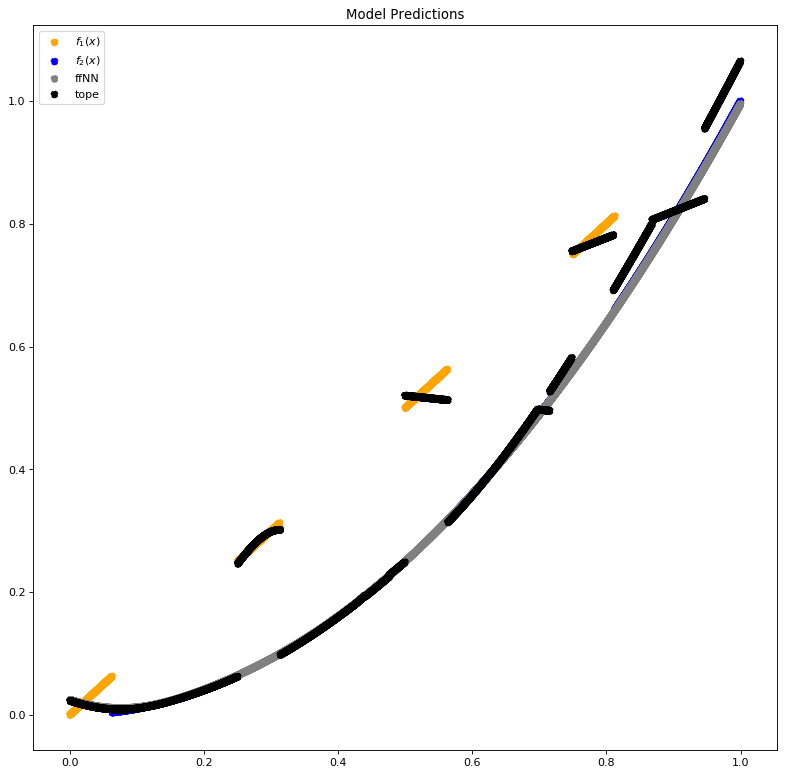

In [50]:
 # Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#
# Plot Signal
# plt.scatter(x,y,color='gray',label='$f(x)$',linestyle='--')
plt.scatter(x_1,y_1,color='orange',label=r'$f_1(x)$',linestyle='--')
plt.scatter(x_2,y_2,color='blue',label=r'$f_2(x)$',linestyle='--')

#--------------------#
# Benchmark Model(s) #
#--------------------#
# Plot ffNN
plt.scatter(x,y_hat_train_Vanilla_ffNN, color = 'gray',linestyle="--",  label='ffNN')
plt.scatter(x,Architope_prediction_y_train, color = 'black',linestyle="--",  label='tope')



# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/DEMO.pdf', format='pdf')

---
# Fin
---